In [98]:
%%time

import os, psutil
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

# machine learning tools
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator, H2ORandomForestEstimator, H2OGradientBoostingEstimator

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

for dirname, _, filenames in os.walk('/dataset/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

CPU times: total: 0 ns
Wall time: 1.3 ms


In [99]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [100]:
%%time
# Get data
train=pd.read_csv('dataset/train.csv')
test=pd.read_csv('dataset/test.csv')
print("Data imported")

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Data imported
Mem. usage decreased to 1.78 Mb (37.5% reduction)
Mem. usage decreased to 1.11 Mb (38.2% reduction)
memory GB:0.57
Memory reduced
CPU times: total: 141 ms
Wall time: 251 ms


features obtained


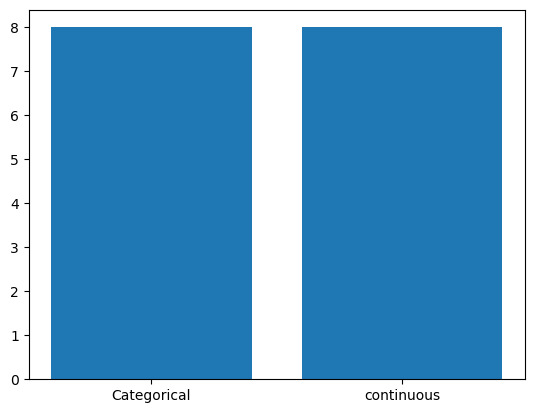

CPU times: total: 203 ms
Wall time: 252 ms


In [101]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in test.columns:
    features.append(feature)
    #print(test.dtypes[feature])
    if test.dtypes[feature]=='int8' or test.dtypes[feature]=='object':
        cat_features.append(feature)
    if test.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [102]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', train.shape)
print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (train.isnull().values.sum())
test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/train.shape[0]))
print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(train.info(),'\n')
print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (20758, 18)
Test data : (13840, 17)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
Missing test data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  8
Continuous features :  8
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-nu

In [103]:
%%time
# Get column titles
#print('*'*40,'\nColumn Names')
#print('*'*40)
#print(features)
#print('*'*40)

# Get sample data
print('*'*40,'\nSample Training Data')
print('*'*40)
print(train.head(),'\n')
#print('*'*40,'\n')
#print('*'*40,'\nSample Test Data')
#print('*'*40)

**************************************** 
Sample Training Data
****************************************
   id  Gender        Age    Height     Weight family_history_with_overweight  \
0   0    Male  24.437500  1.700195   81.68750                            yes   
1   1  Female  18.000000  1.559570   57.00000                            yes   
2   2  Female  18.000000  1.711914   50.15625                            yes   
3   3  Female  20.953125  1.710938  131.25000                            yes   
4   4    Male  31.640625  1.914062   93.81250                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.982422   Sometimes    no  2.763672  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880859  1.412109   Sometimes    no  1.910156  no  0.866211   
3  yes  3.000000  3.000000   Sometimes    no  1.673828  no  1.467773   
4  yes  2.679688  1.971680   Sometimes    no  1.979492 

In [104]:
%%time
# Get column titles
#print('*'*40,'\nColumn Names')
#print('*'*40)
#print(features)
#print('*'*40)

# Get sample data
print('*'*40,'\nSample Test Data')
print('*'*40)
print(test.head(),'\n')
#print('*'*40,'\n')
#print('*'*40,'\nSample Test Data')
#print('*'*40)

**************************************** 
Sample Test Data
****************************************
      id  Gender        Age    Height    Weight  \
0  20758    Male  26.906250  1.848633  120.6250   
1  20759  Female  21.000000  1.599609   66.0000   
2  20760  Female  26.000000  1.643555  111.6250   
3  20761    Male  20.984375  1.552734  103.6875   
4  20762  Female  26.000000  1.626953  104.8125   

  family_history_with_overweight FAVC      FCVC       NCP       CAEC SMOKE  \
0                            yes  yes  2.939453  3.000000  Sometimes    no   
1                            yes  yes  2.000000  1.000000  Sometimes    no   
2                            yes  yes  3.000000  3.000000  Sometimes    no   
3                            yes  yes  2.000000  2.978516  Sometimes    no   
4                            yes  yes  3.000000  3.000000  Sometimes    no   

       CH2O SCC       FAF       TUE       CALC                 MTRANS  
0  2.826172  no  0.855469  0.000000  Sometimes  Publ

Training data (blue), Test Data (red)


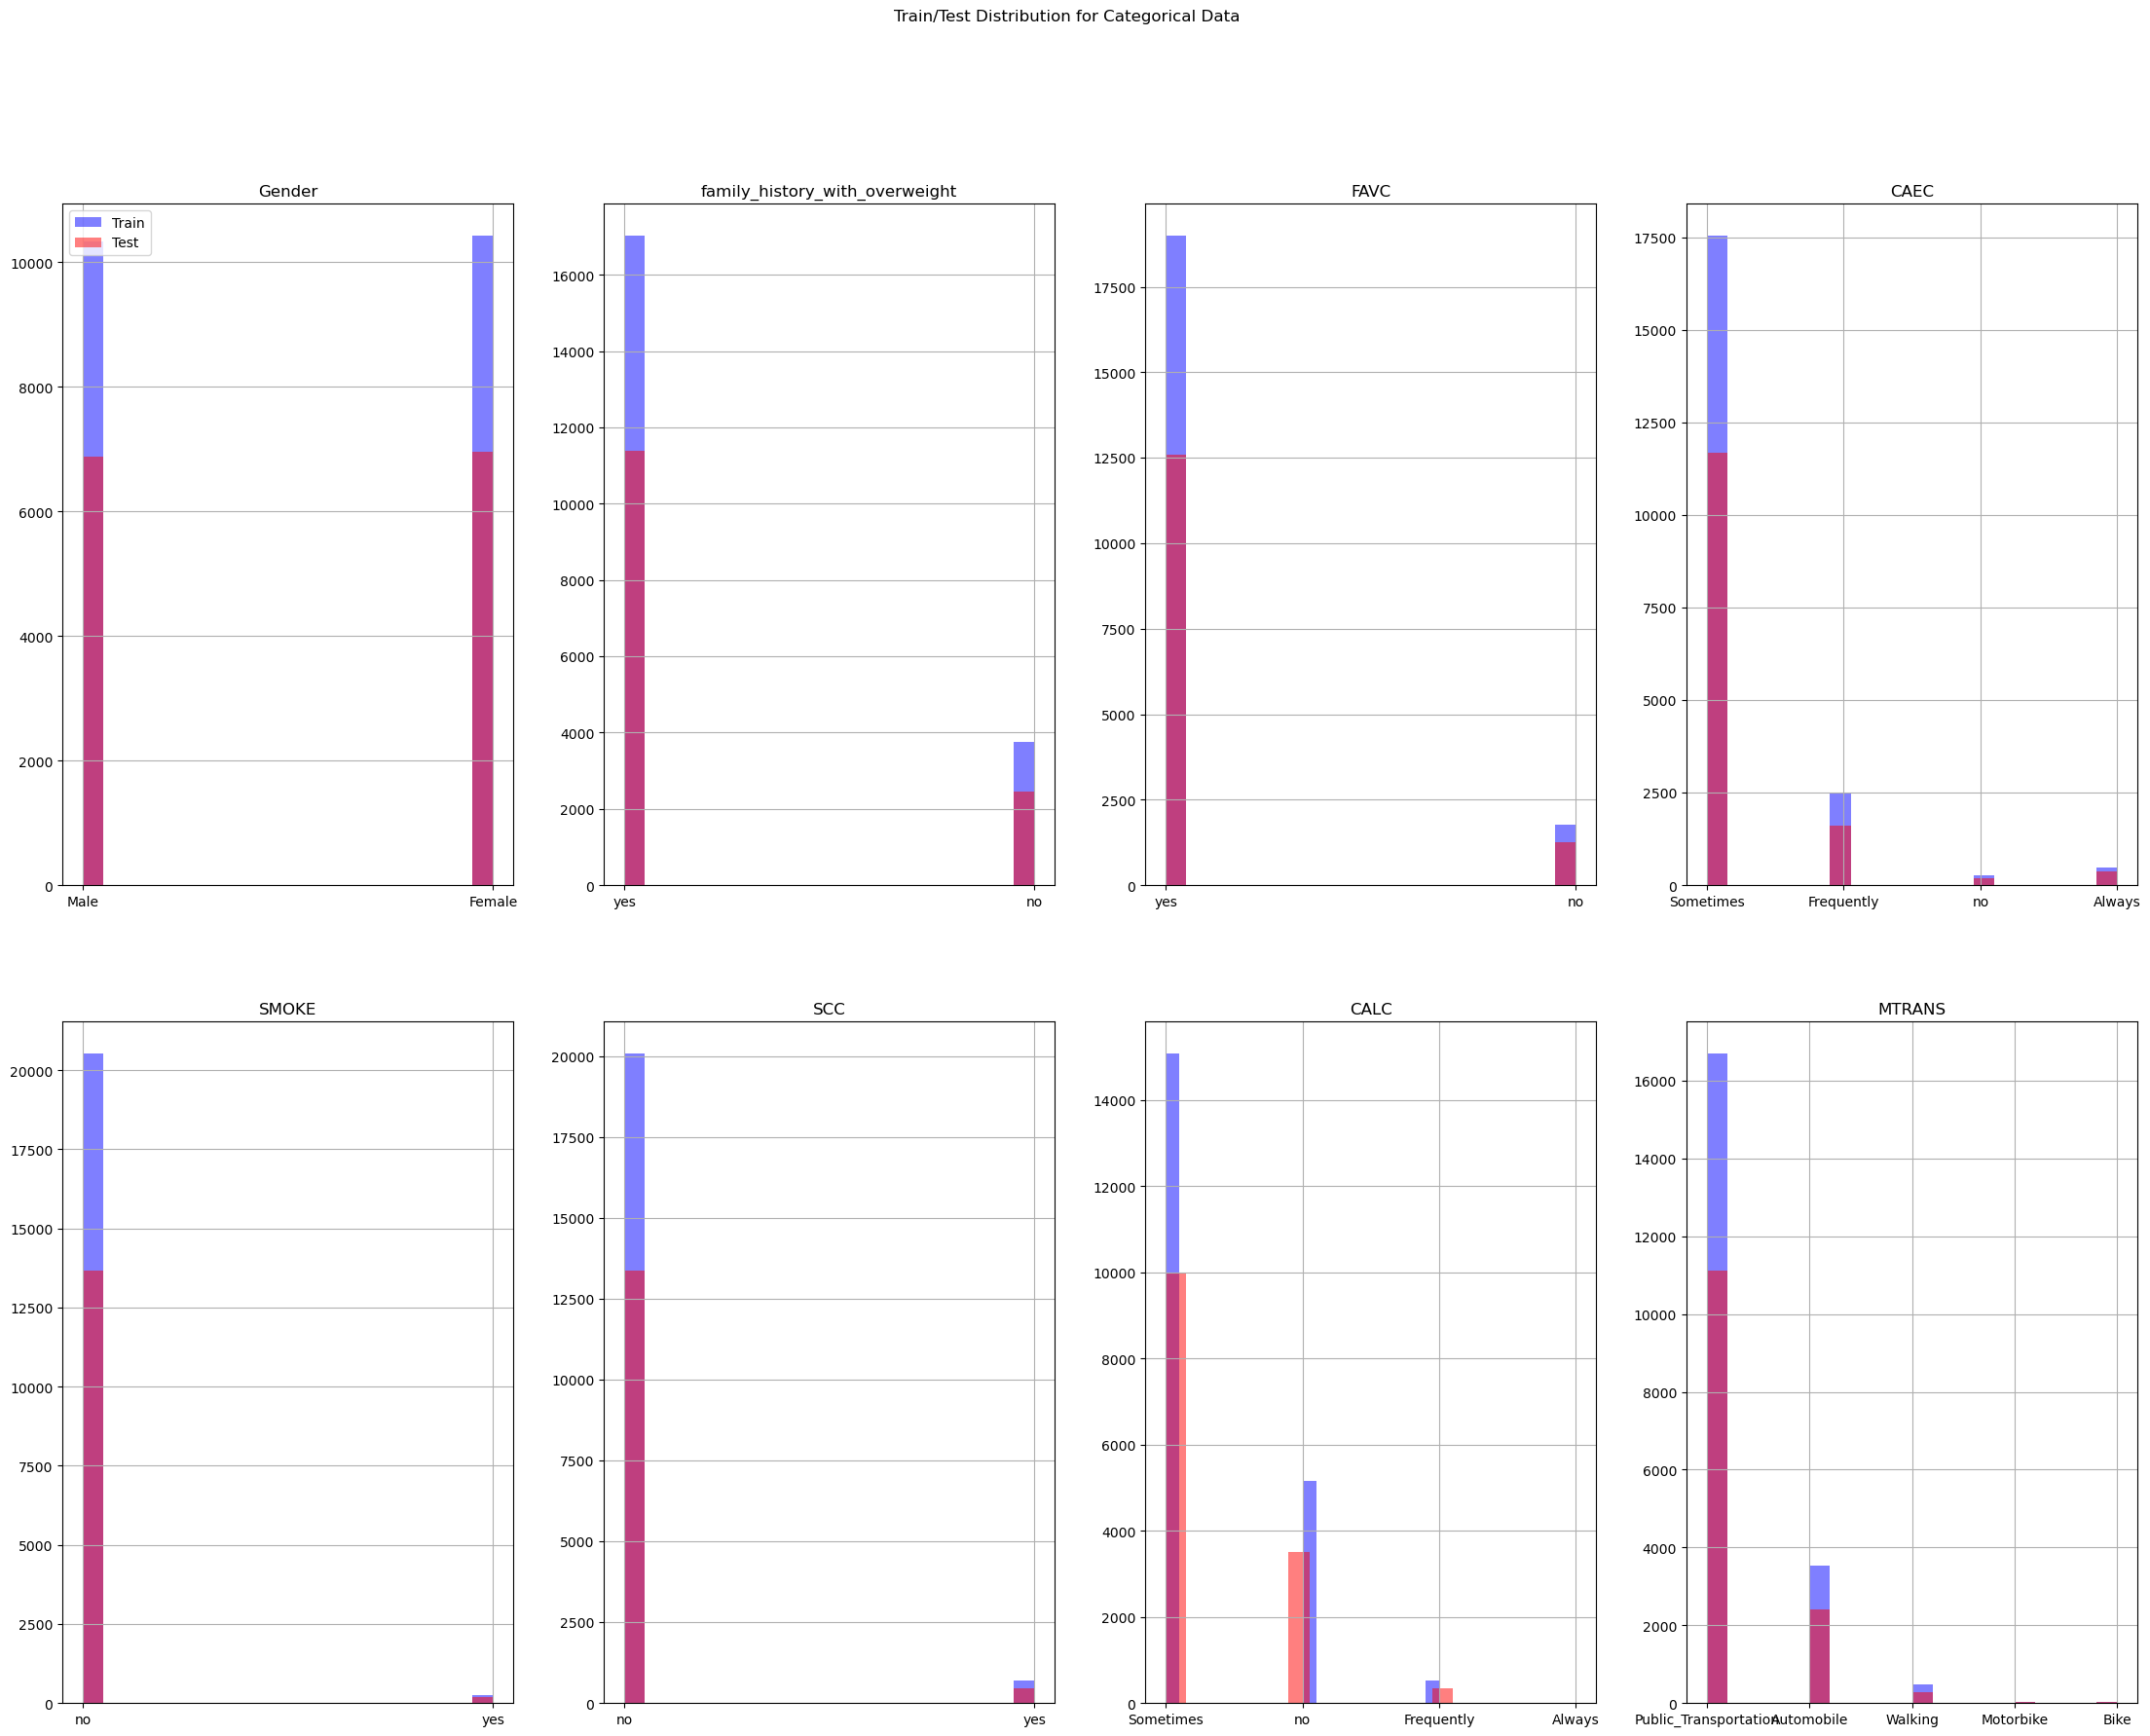

In [105]:
train_outliers=train[cat_features]
test_outliers=test[cat_features]
print('Training data (blue), Test Data (red)')
fig = plt.figure(figsize = (27.5, 20))
for idx, i in enumerate(train_outliers.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers.columns)/4)), 4, idx+1)
    train_outliers.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label="Train")
    test_outliers.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label="Test")
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train/Test Distribution for Categorical Data')
plt.show()

Training data (blue), Test Data (red)


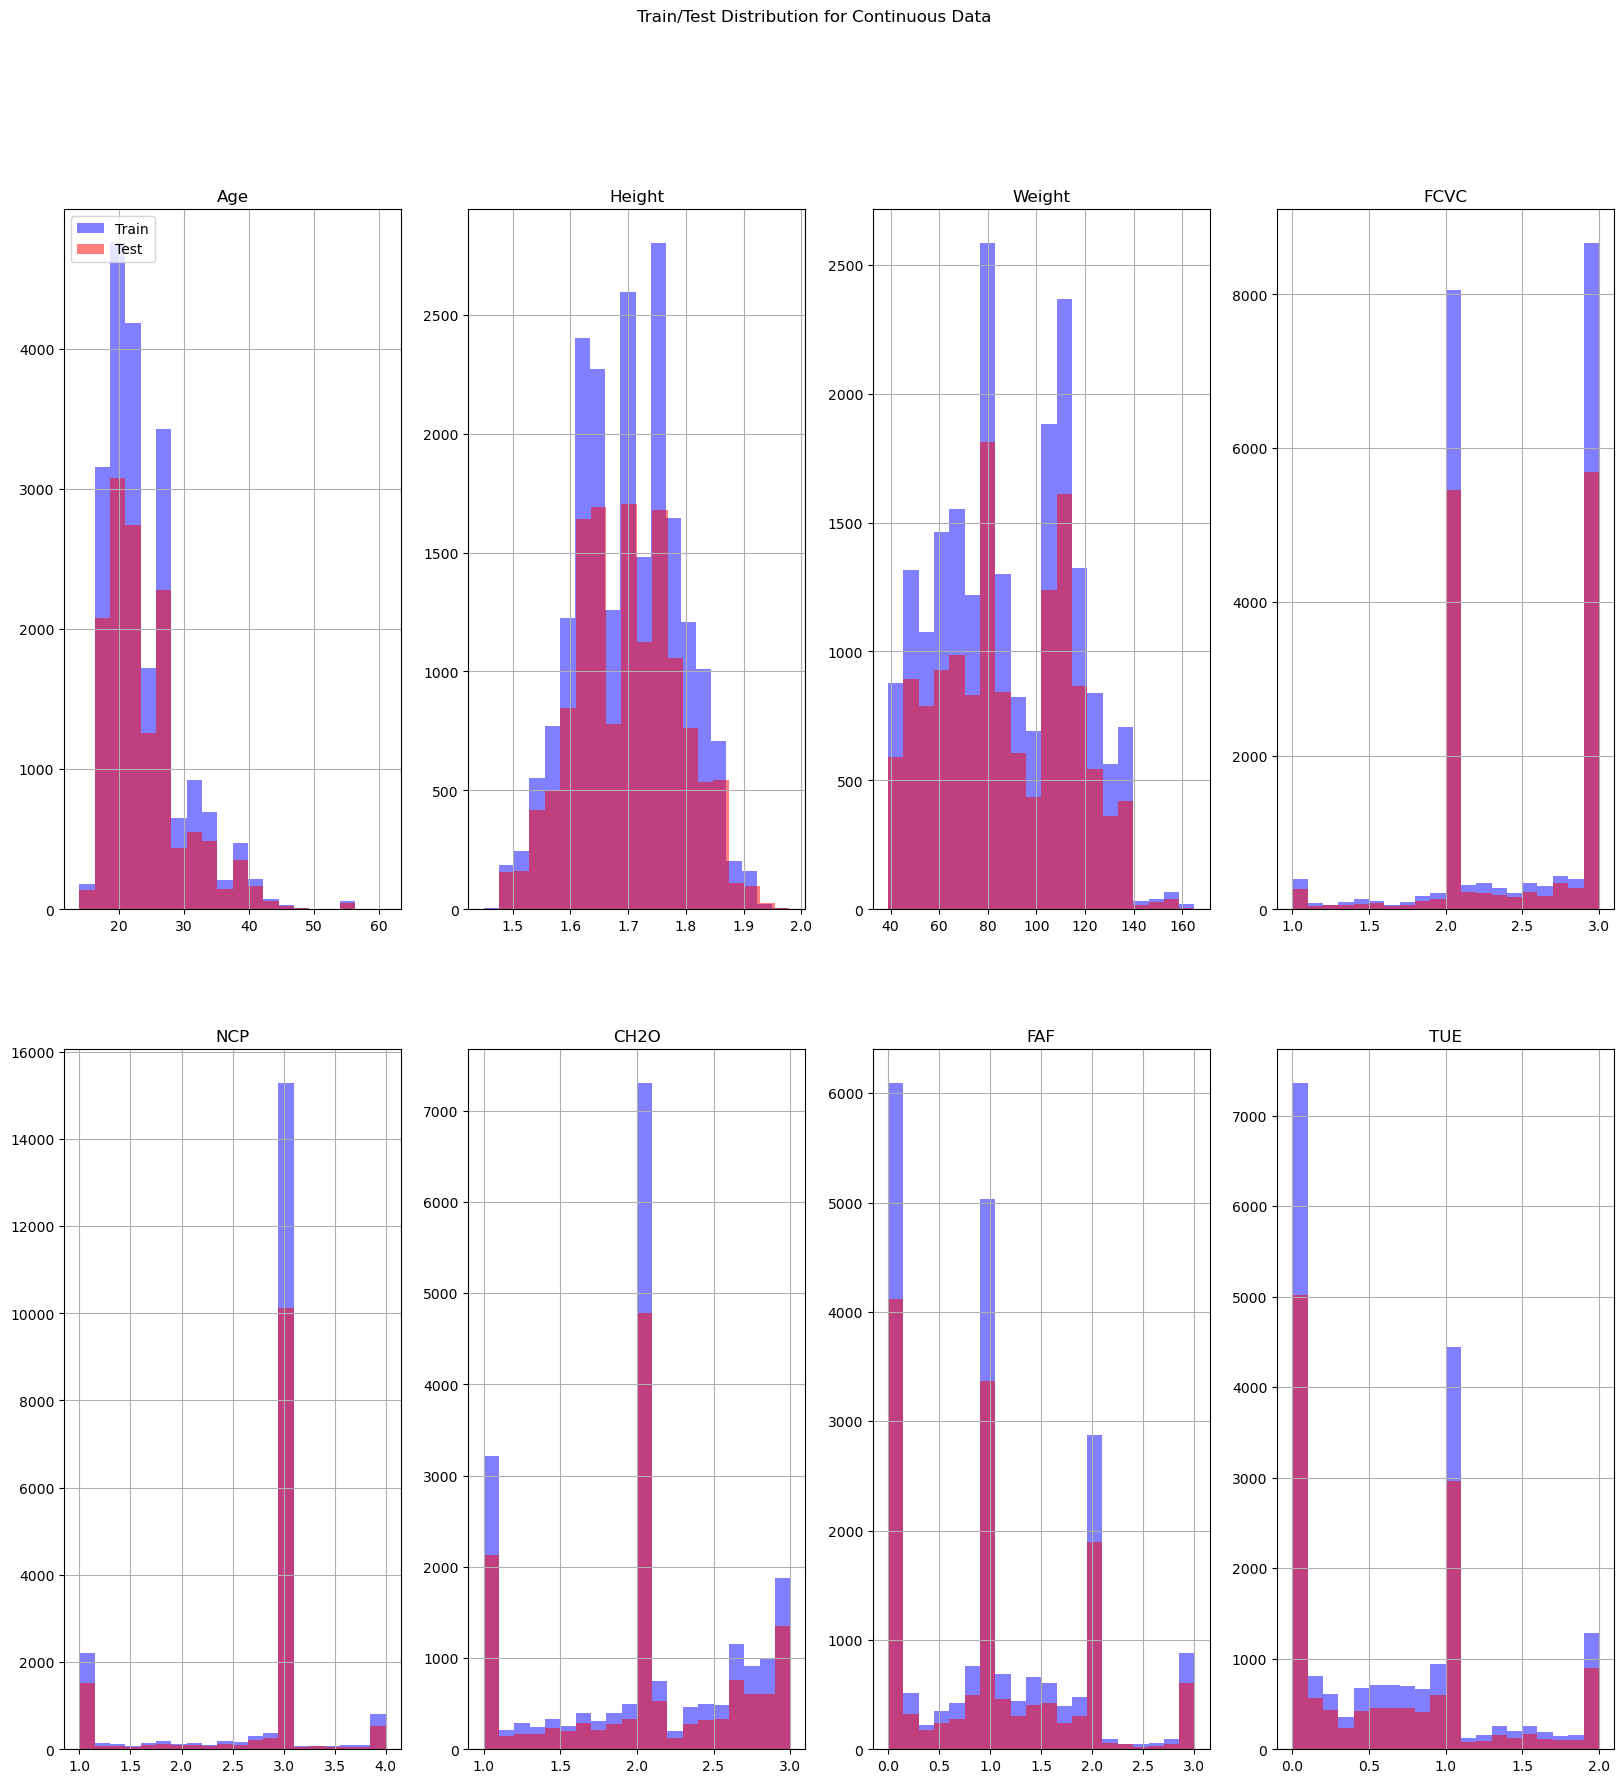

In [106]:
train_outliers=train[cont_features]
test_outliers=test[cont_features]
print('Training data (blue), Test Data (red)')
fig = plt.figure(figsize = (20, 20))
for idx, i in enumerate(train_outliers.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers.columns)/4)), 4, idx+1)
    train_outliers.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label="Train")
    test_outliers.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label="Test")
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train/Test Distribution for Continuous Data')
plt.show()

In [107]:
pd.Categorical(train['NObeyesdad'])

['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', 'Obesity_Type_III', 'Overweight_Level_II', ..., 'Obesity_Type_II', 'Insufficient_Weight', 'Obesity_Type_II', 'Overweight_Level_II', 'Obesity_Type_II']
Length: 20758
Categories (7, object): ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

Distribution of continuous features, red=Insufficient_Weight, blue=Normal_Weight


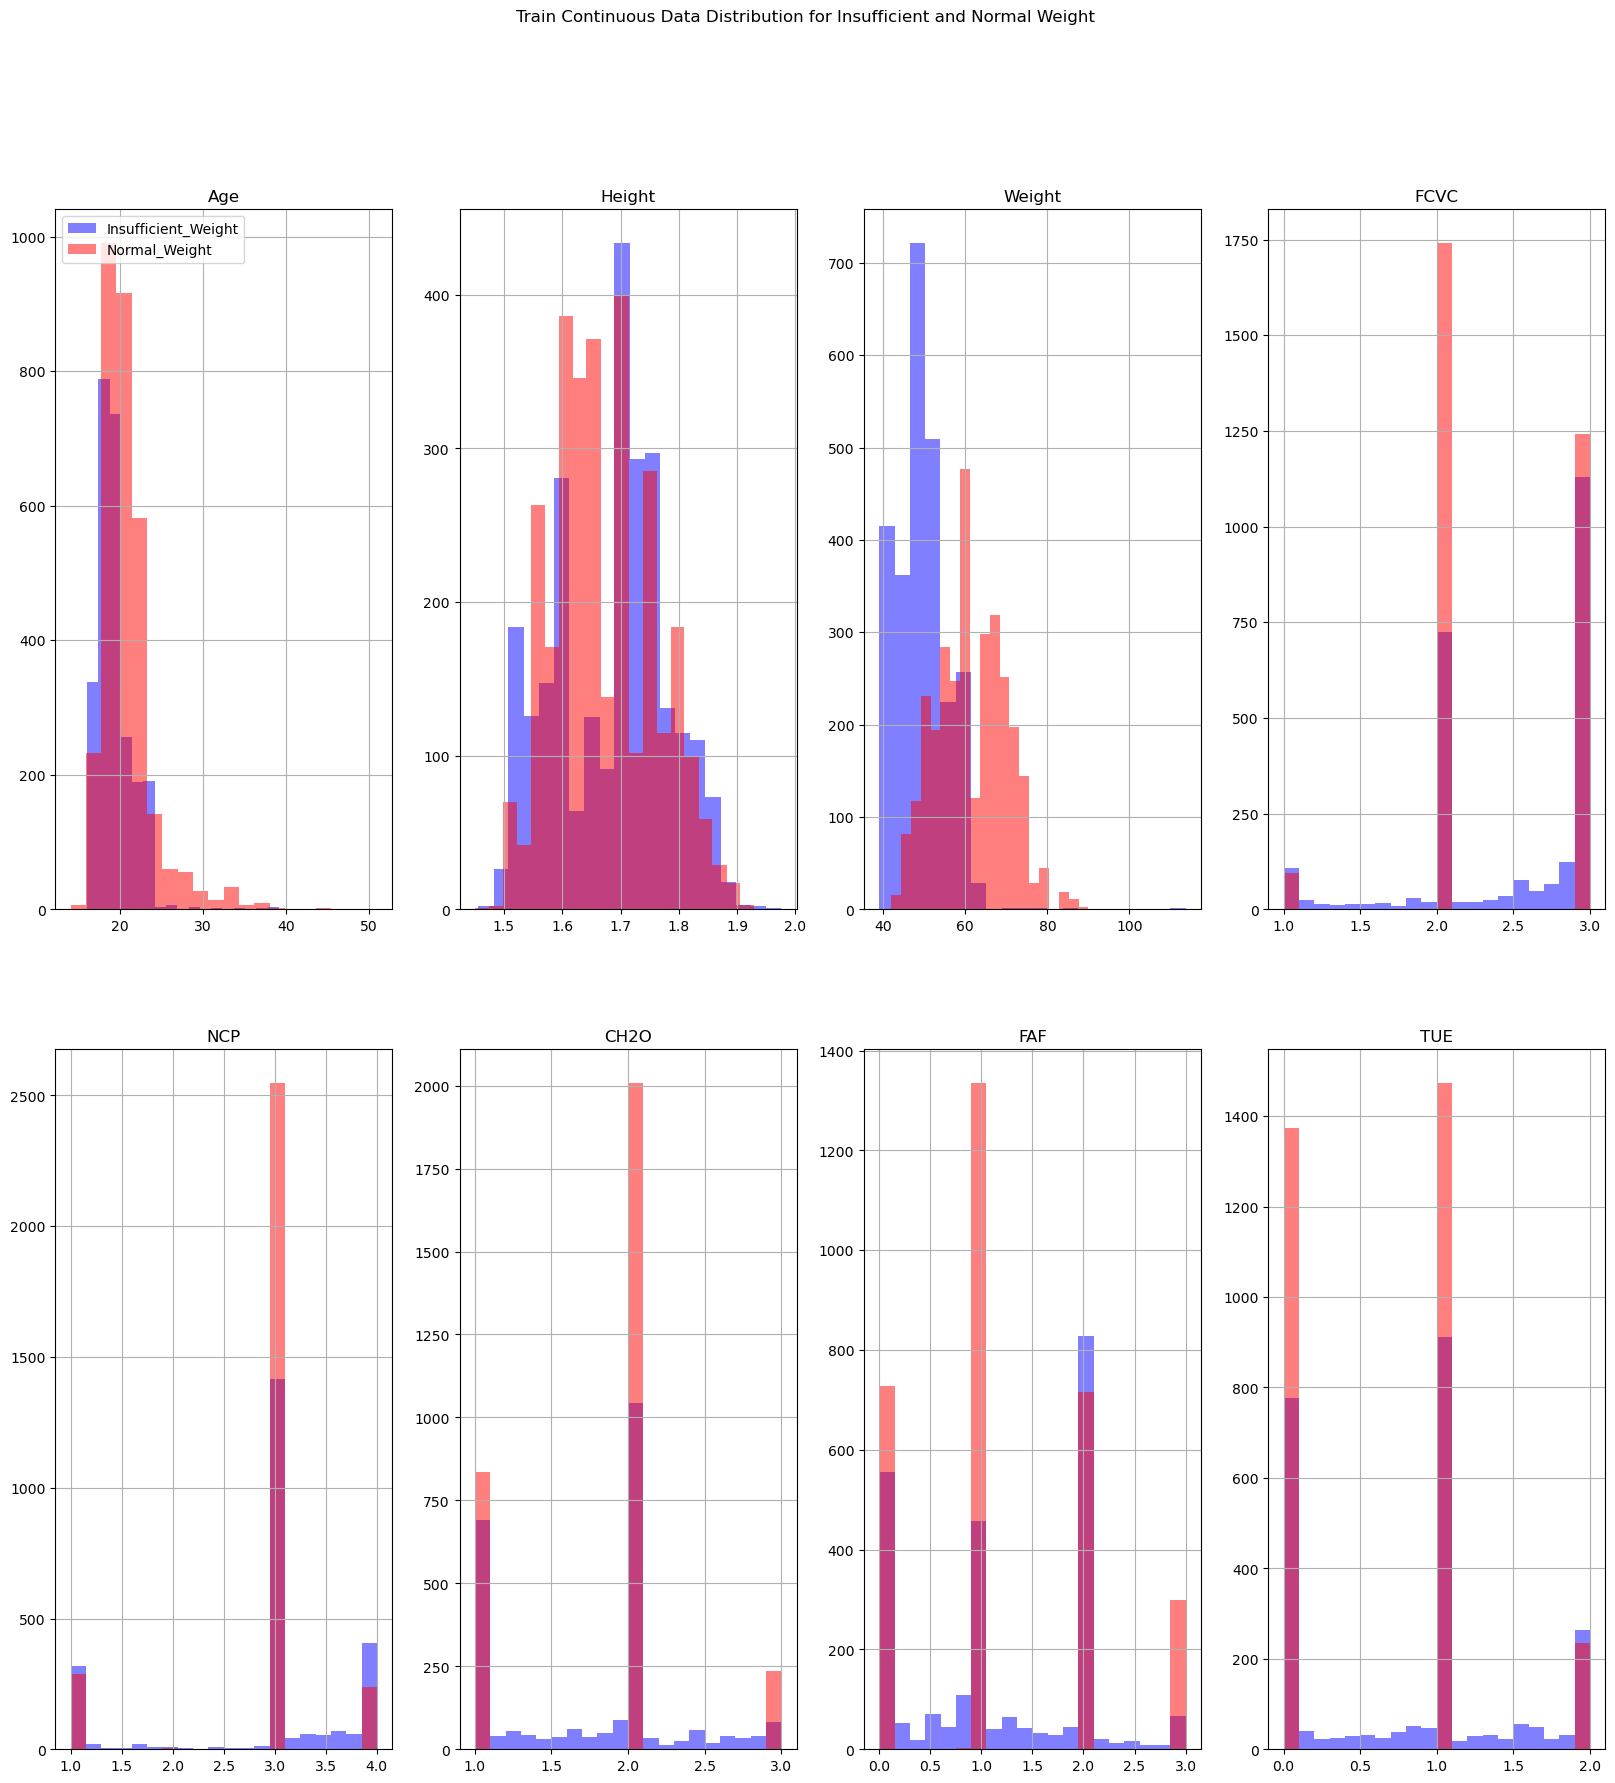

CPU times: total: 2.27 s
Wall time: 3.4 s


In [108]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Insufficient_Weight']
train_1=train[train.NObeyesdad=='Normal_Weight']

train_outliers_0=train_0[cont_features]
train_outliers_1=train_1[cont_features]

print('Distribution of continuous features, red=Insufficient_Weight, blue=Normal_Weight')
fig = plt.figure(figsize = (20, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label='Insufficient_Weight')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label= 'Normal_Weight')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Continuous Data Distribution for Insufficient and Normal Weight')
plt.show()

Distribution of continuous features, red=Insufficient_Weight, blue=Normal_Weight


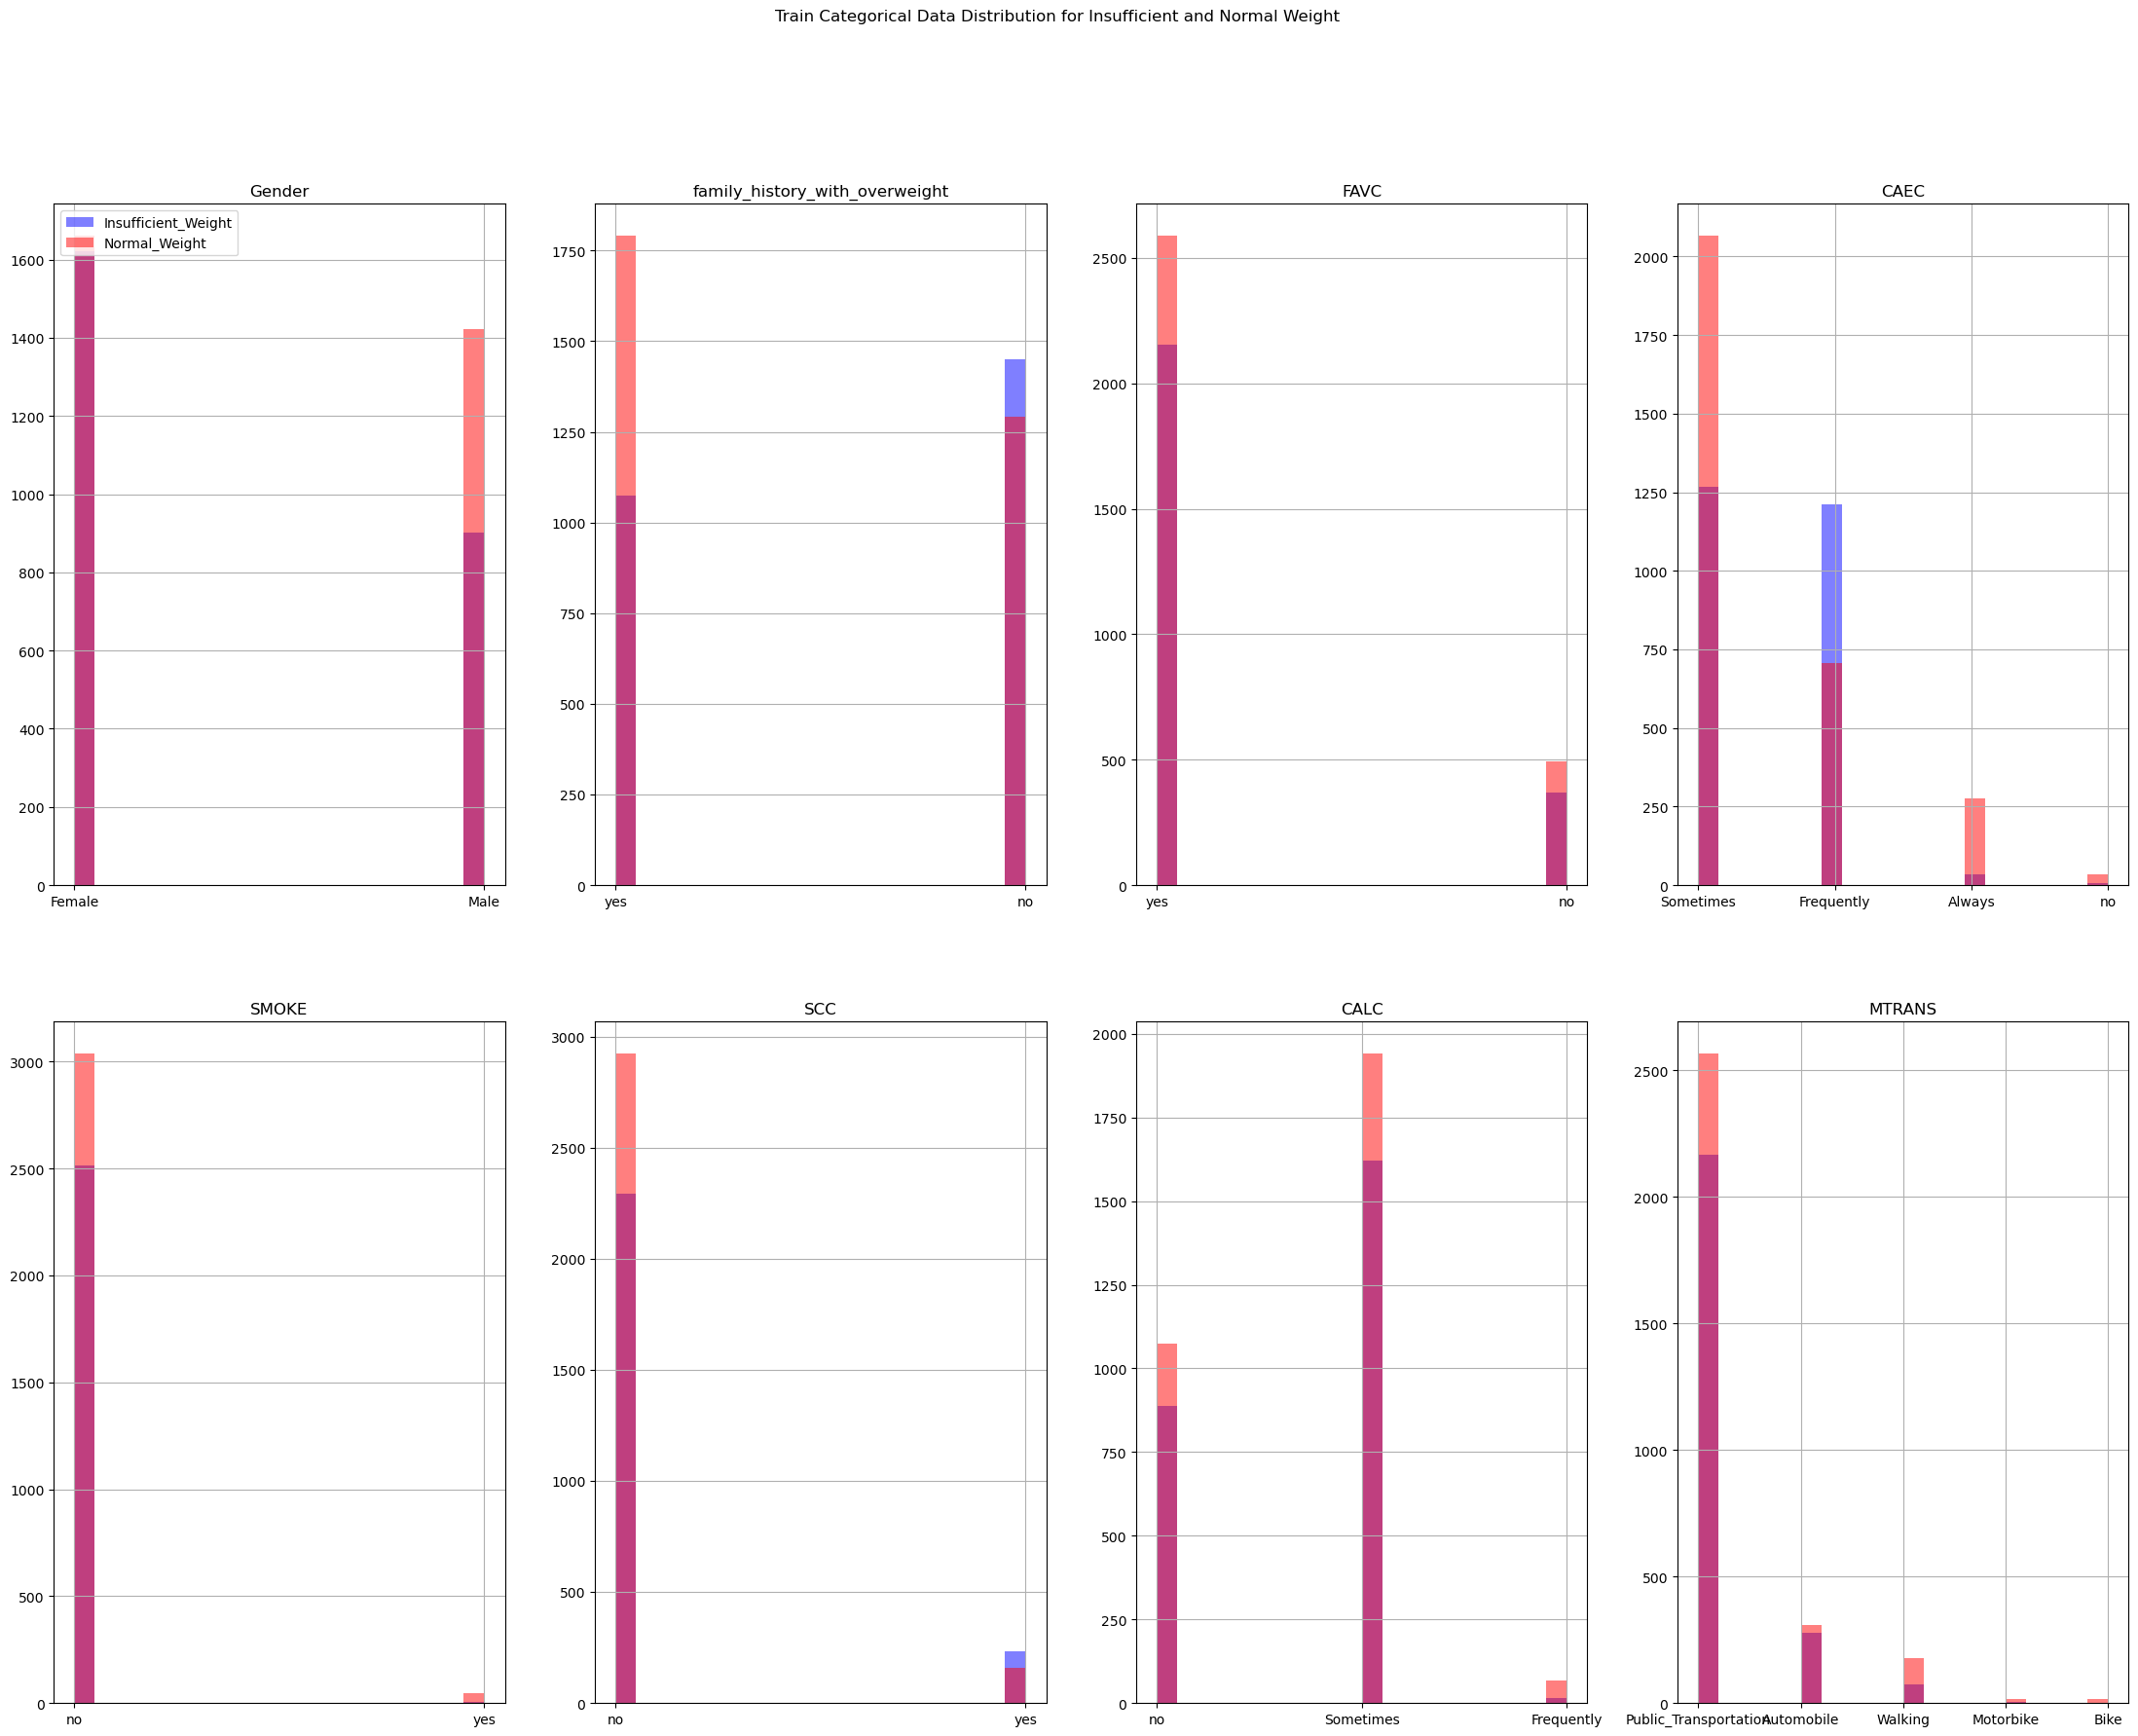

CPU times: total: 1.52 s
Wall time: 2.97 s


In [109]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Insufficient_Weight']
train_1=train[train.NObeyesdad=='Normal_Weight']

train_outliers_0=train_0[cat_features]
train_outliers_1=train_1[cat_features]

print('Distribution of continuous features, red=Insufficient_Weight, blue=Normal_Weight')
fig = plt.figure(figsize = (27.5, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label='Insufficient_Weight')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label= 'Normal_Weight')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Categorical Data Distribution for Insufficient and Normal Weight')
plt.show()

Distribution of continuous features, red=Overweight_Level_I, blue=Overweight_Level_II


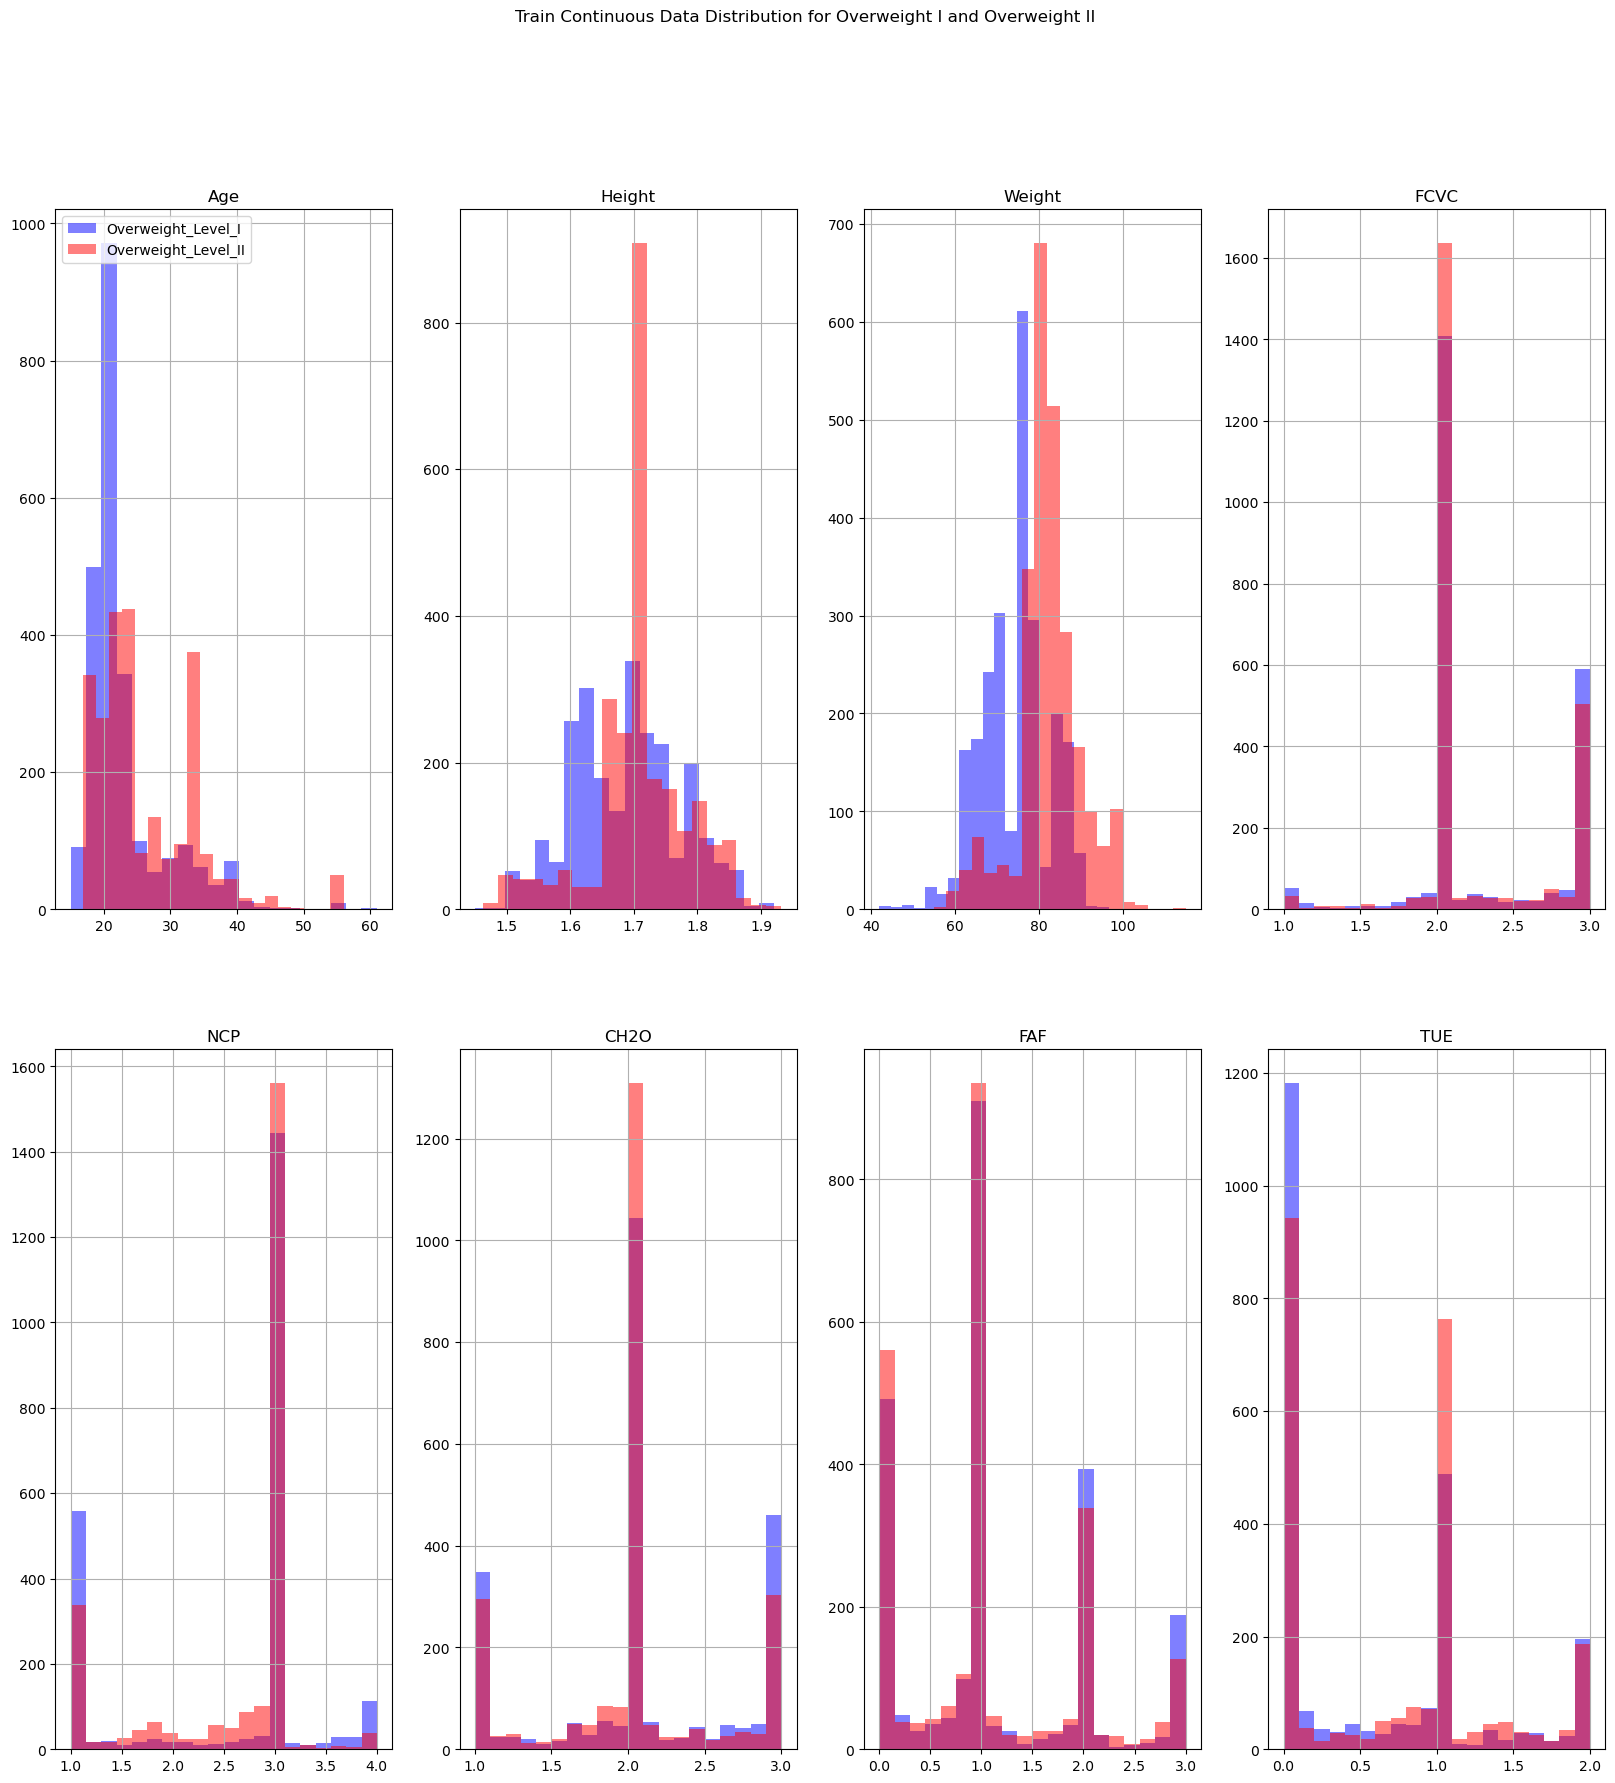

CPU times: total: 2.14 s
Wall time: 3.14 s


In [110]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Overweight_Level_I']
train_1=train[train.NObeyesdad=='Overweight_Level_II']

train_outliers_0=train_0[cont_features]
train_outliers_1=train_1[cont_features]

print('Distribution of continuous features, red=Overweight_Level_I, blue=Overweight_Level_II')
fig = plt.figure(figsize = (20, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5,label='Overweight_Level_I')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5,label='Overweight_Level_II')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Continuous Data Distribution for Overweight I and Overweight II')
plt.show()

Distribution of categorical features, red=Overweight_Level_I, blue=Overweight_Level_II


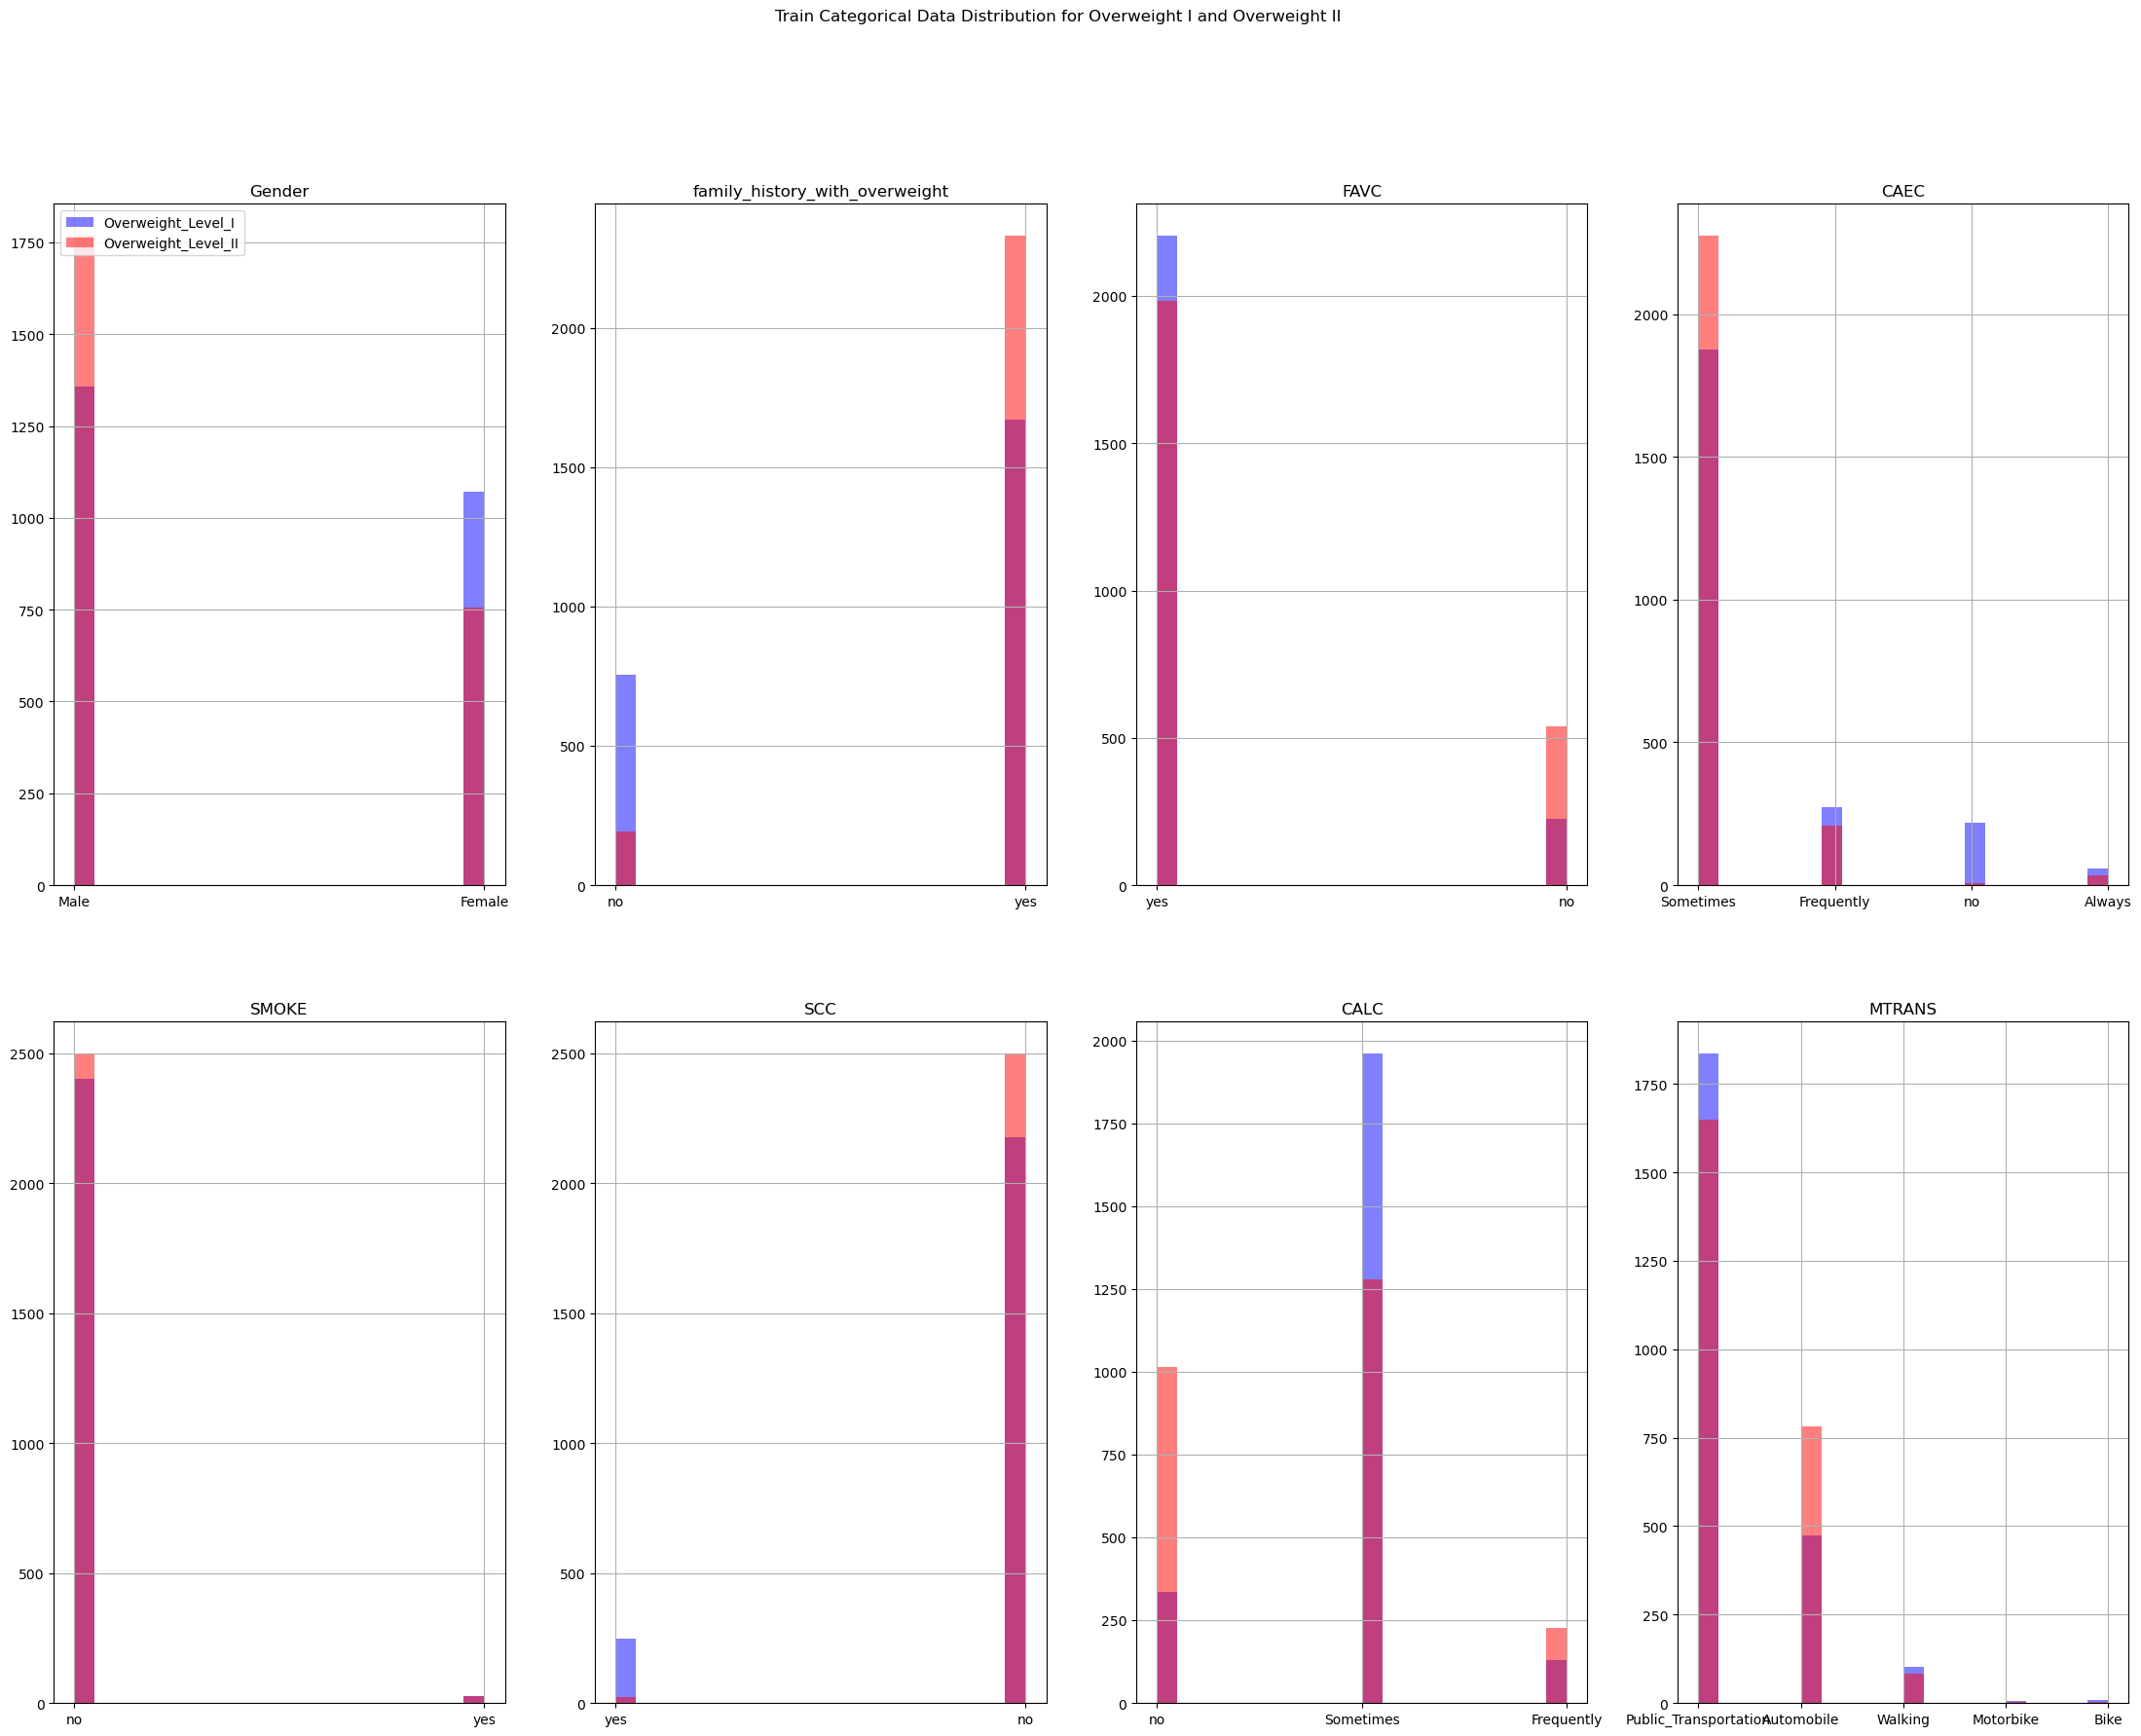

CPU times: total: 1.94 s
Wall time: 2.84 s


In [111]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Overweight_Level_I']
train_1=train[train.NObeyesdad=='Overweight_Level_II']

train_outliers_0=train_0[cat_features]
train_outliers_1=train_1[cat_features]

print('Distribution of categorical features, red=Overweight_Level_I, blue=Overweight_Level_II')
fig = plt.figure(figsize = (27.5, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5,label='Overweight_Level_I')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5,label='Overweight_Level_II')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Categorical Data Distribution for Overweight I and Overweight II')
plt.show()

Distribution of continuous features, red=Obesity_Type_I, blue=Obesity_Type_II, green=Obesity_Type_III


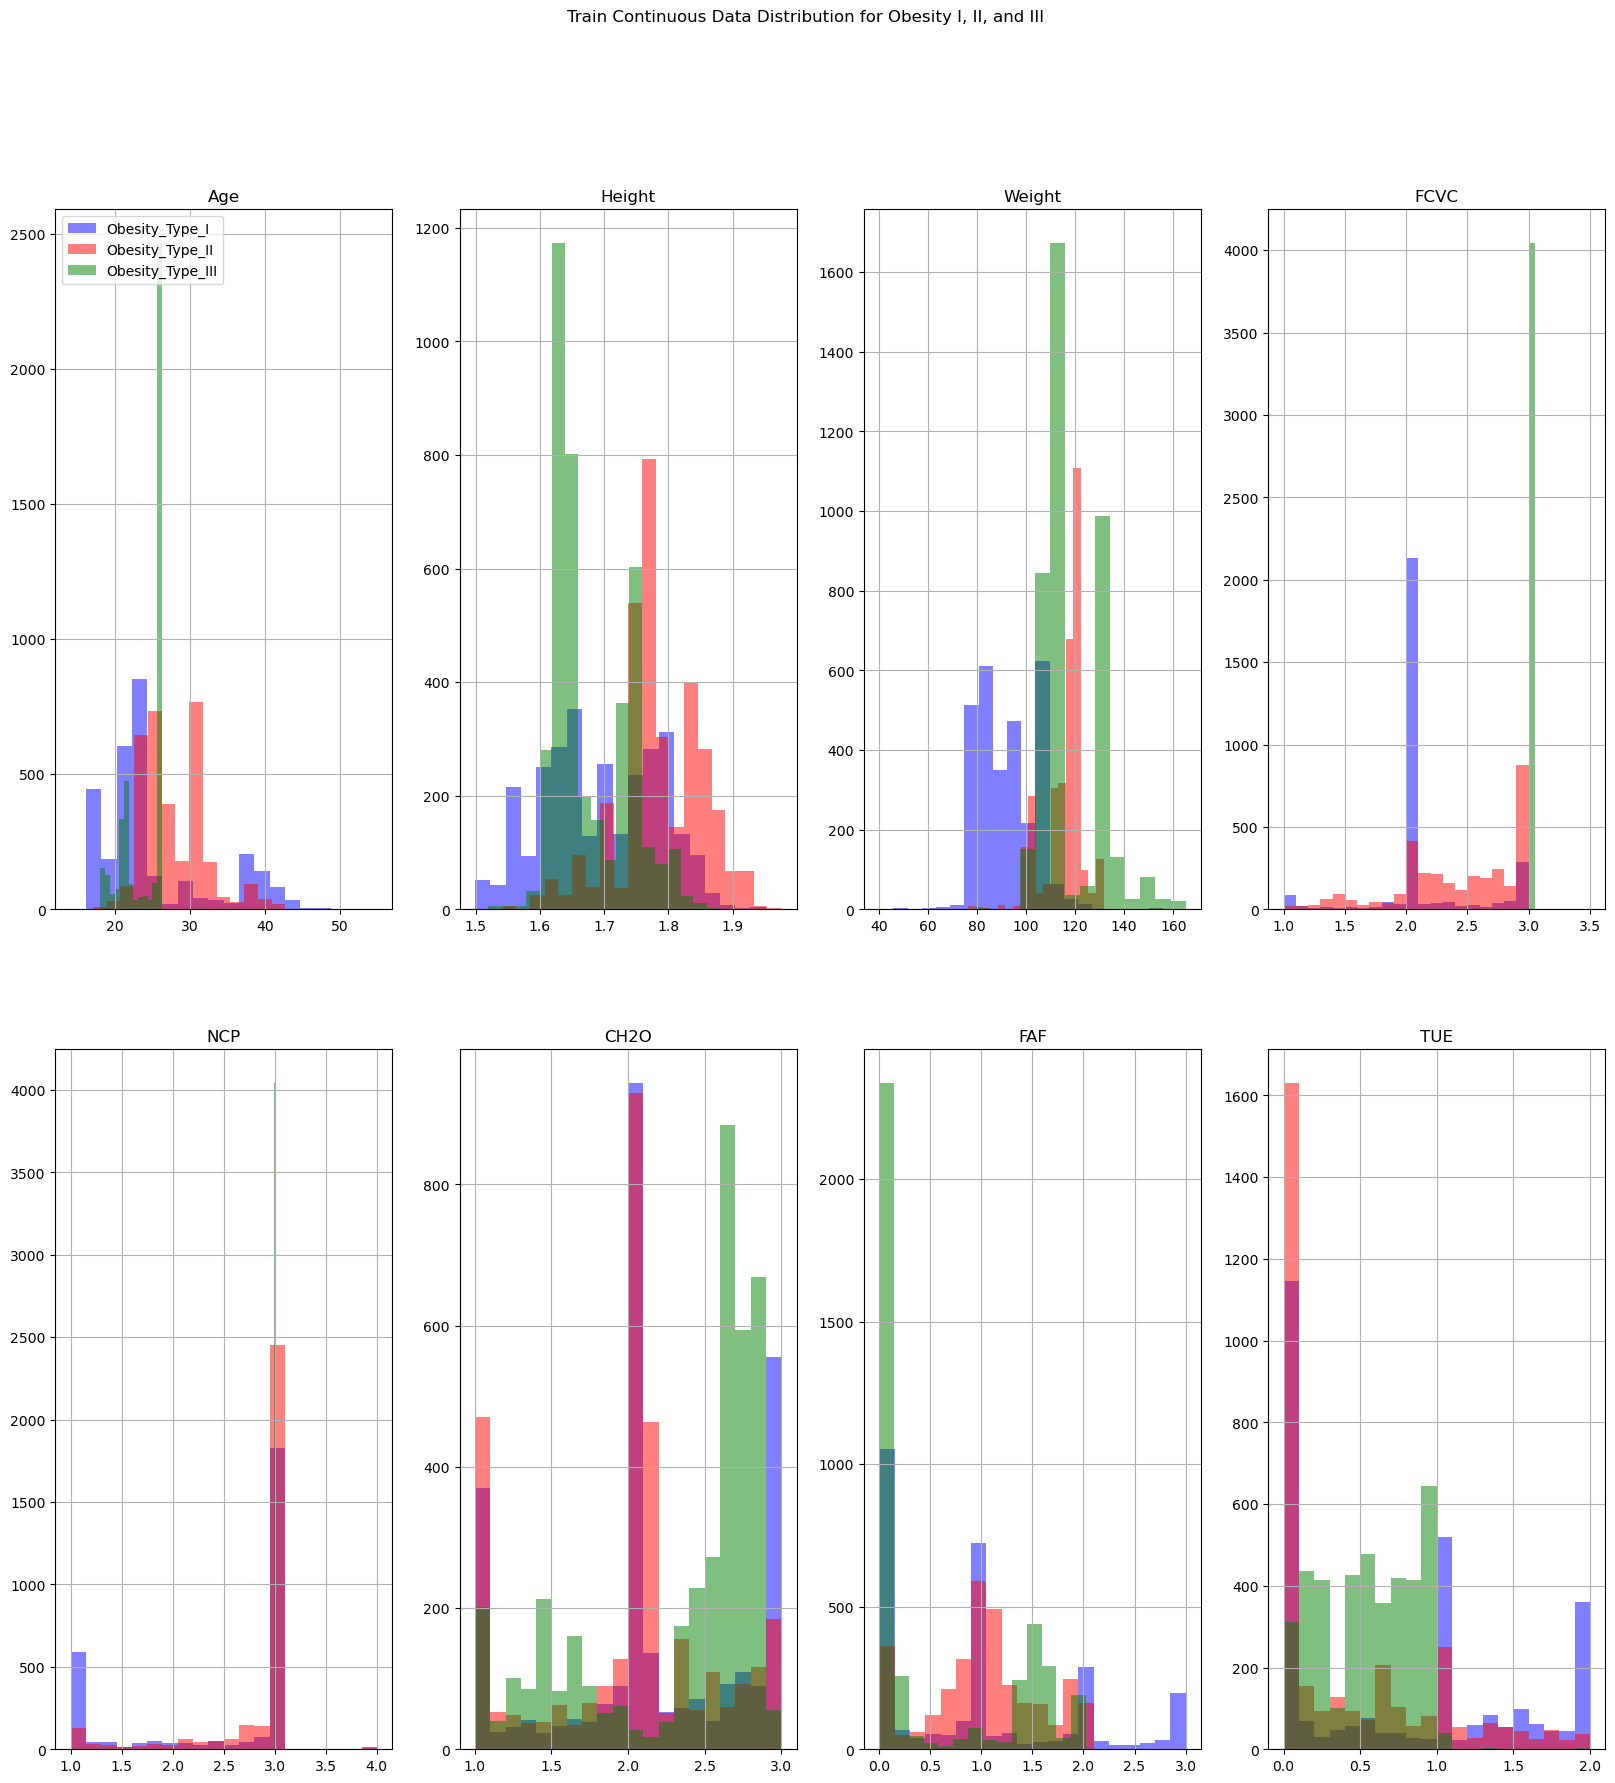

CPU times: total: 2.67 s
Wall time: 4.36 s


In [112]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Obesity_Type_I']
train_1=train[train.NObeyesdad=='Obesity_Type_II']
train_2=train[train.NObeyesdad=='Obesity_Type_III']

train_outliers_0=train_0[cont_features]
train_outliers_1=train_1[cont_features]
train_outliers_2=train_2[cont_features]

print('Distribution of continuous features, red=Obesity_Type_I, blue=Obesity_Type_II, green=Obesity_Type_III')
fig = plt.figure(figsize = (20, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label = 'Obesity_Type_I')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label = 'Obesity_Type_II')
    train_outliers_2.iloc[:, idx].hist(bins = 20,color='g',alpha=0.5, label = 'Obesity_Type_III')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Continuous Data Distribution for Obesity I, II, and III')
plt.show()

Distribution of categorical features, red=Obesity_Type_I, blue=Obesity_Type_II, green=Obesity_Type_III


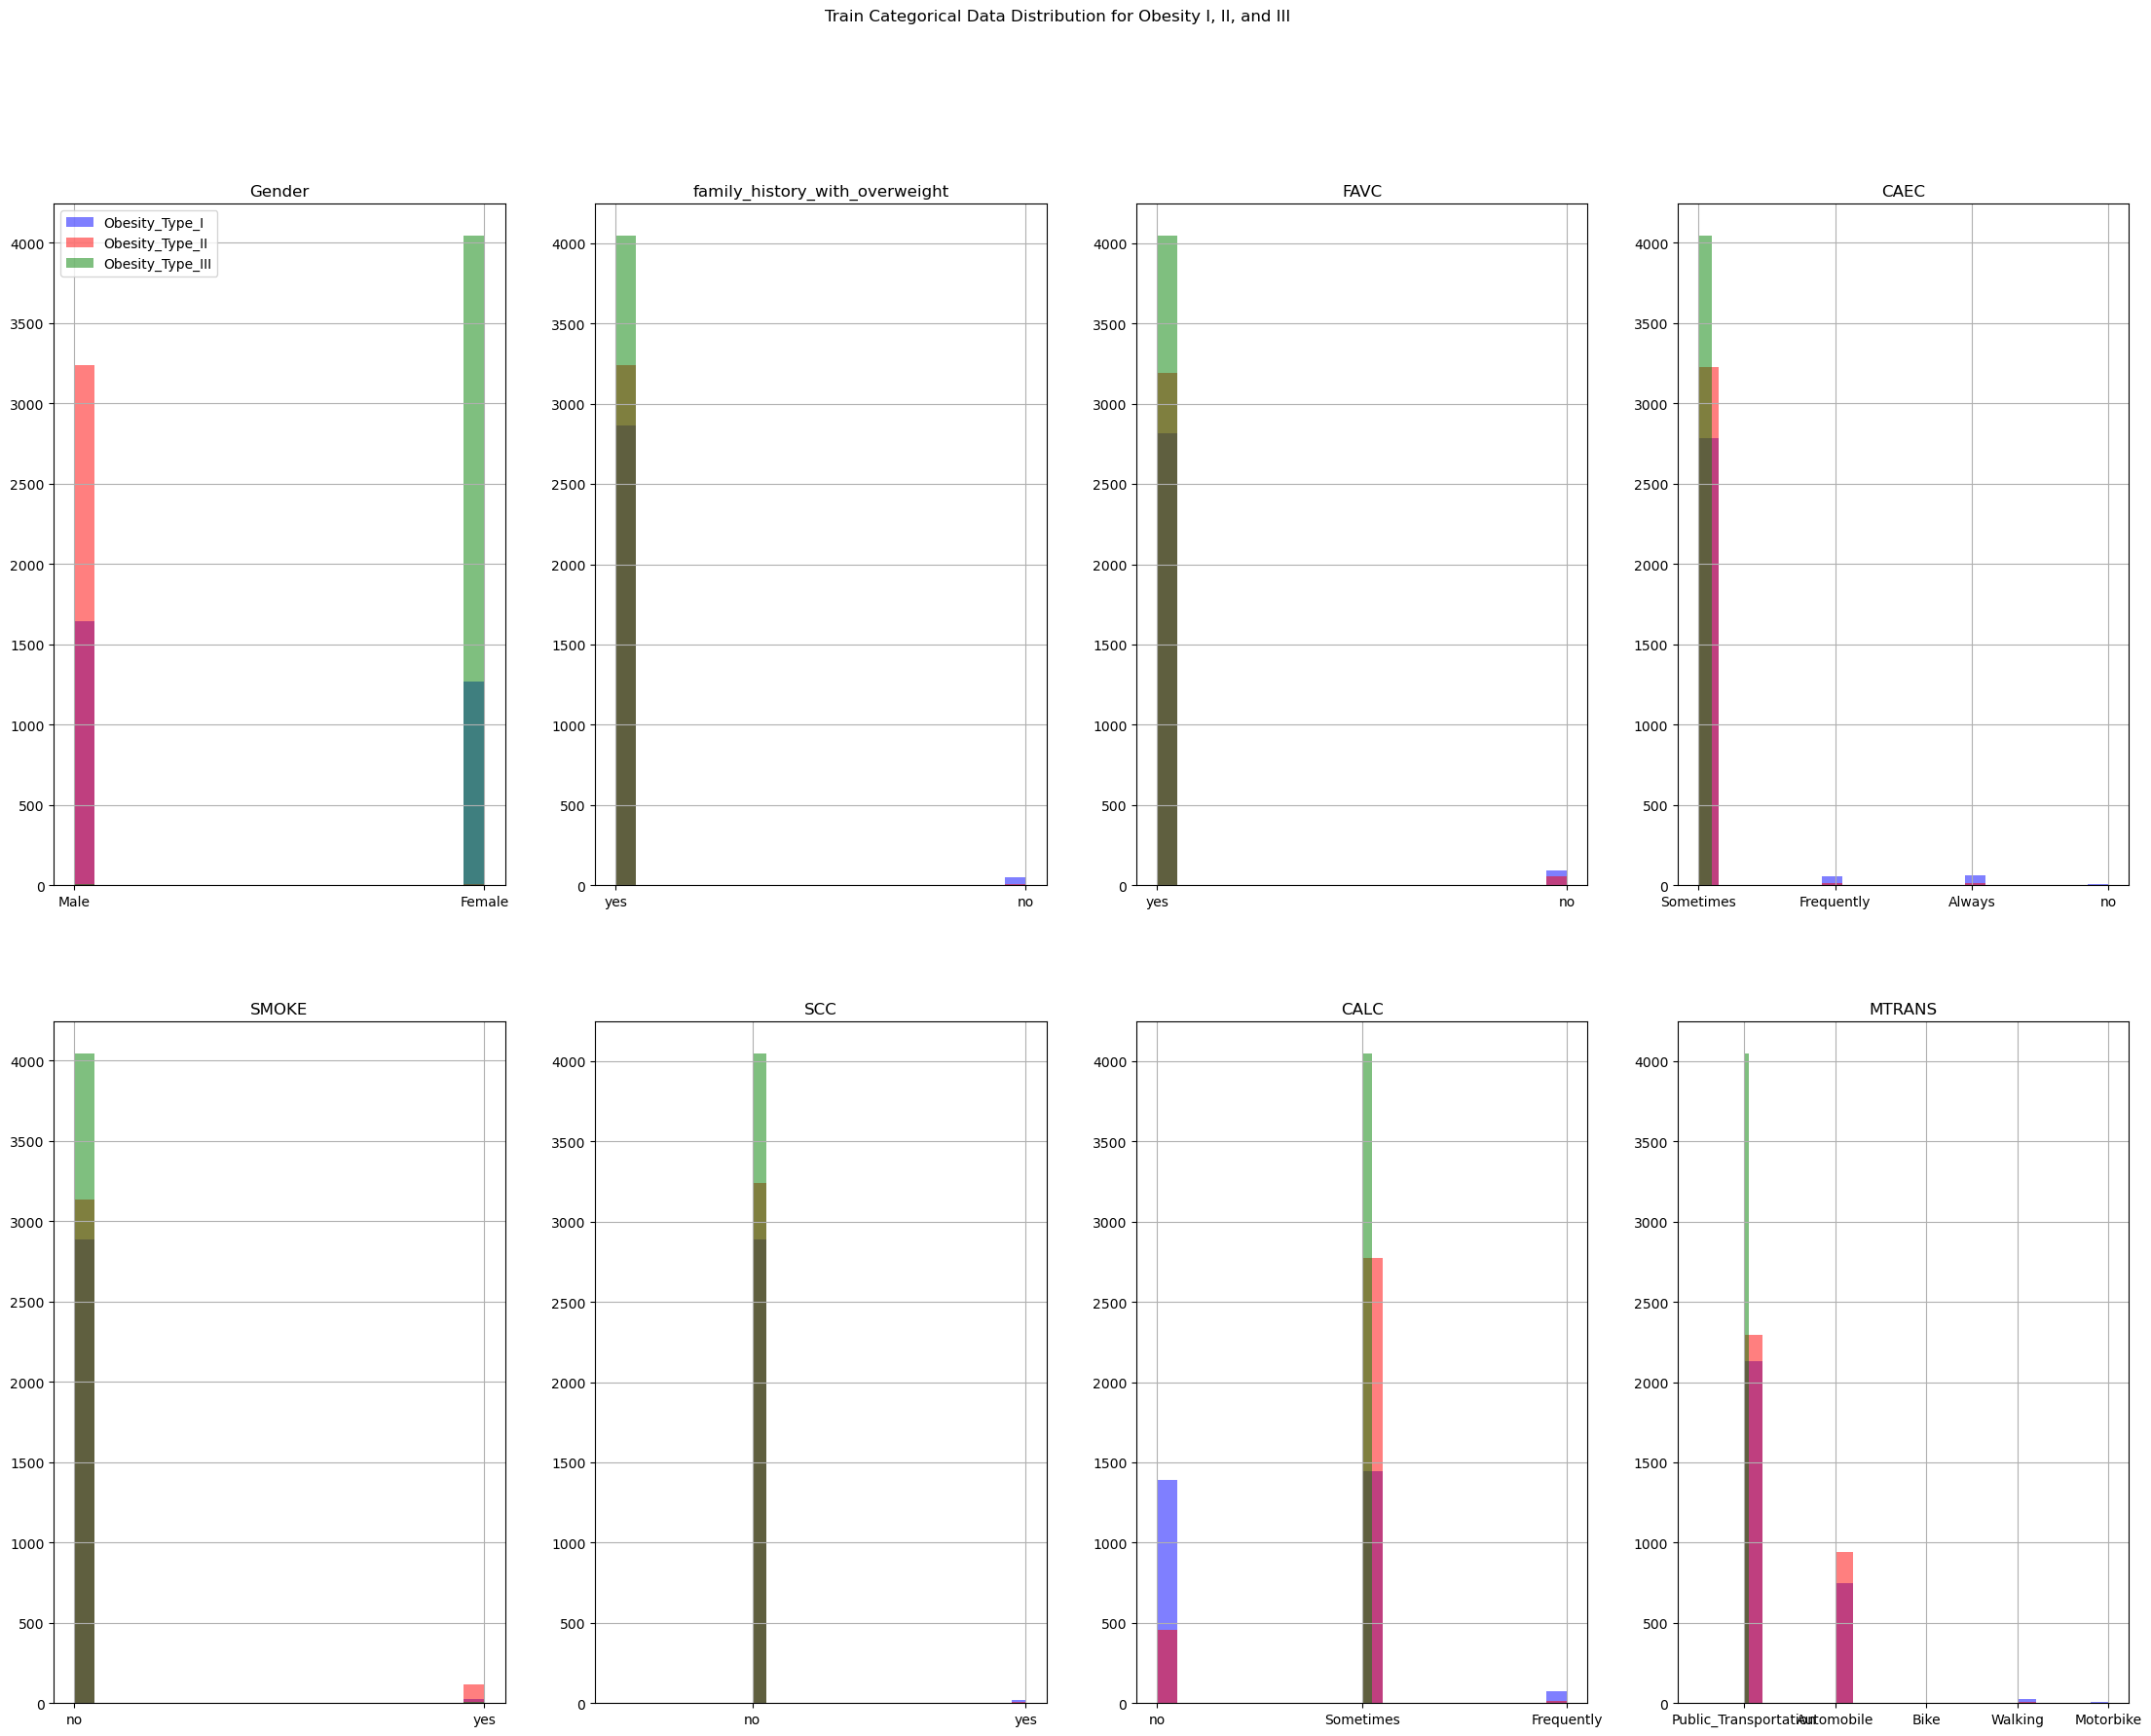

CPU times: total: 1.94 s
Wall time: 3.38 s


In [113]:
%%time
# continuous features by target value

# separate data by target value
train_0=train[train.NObeyesdad=='Obesity_Type_I']
train_1=train[train.NObeyesdad=='Obesity_Type_II']
train_2=train[train.NObeyesdad=='Obesity_Type_III']

train_outliers_0=train_0[cat_features]
train_outliers_1=train_1[cat_features]
train_outliers_2=train_2[cat_features]

print('Distribution of categorical features, red=Obesity_Type_I, blue=Obesity_Type_II, green=Obesity_Type_III')
fig = plt.figure(figsize = (27.5, 20))
for idx, i in enumerate(train_outliers_0.columns):
    fig.add_subplot(int(np.ceil(len(train_outliers_0.columns)/4)), 4, idx+1)
    train_outliers_0.iloc[:, idx].hist(bins=20,color='b',alpha=0.5, label = 'Obesity_Type_I')
    train_outliers_1.iloc[:, idx].hist(bins = 20,color='r',alpha=0.5, label = 'Obesity_Type_II')
    train_outliers_2.iloc[:, idx].hist(bins = 20,color='g',alpha=0.5, label = 'Obesity_Type_III')
    plt.subplots_adjust(hspace=0.2)
    if(idx == 0):
        plt.subplots_adjust(hspace=0.2)
        plt.legend(loc="upper left")
    plt.title(i)
plt.suptitle('Train Categorical Data Distribution for Obesity I, II, and III')
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

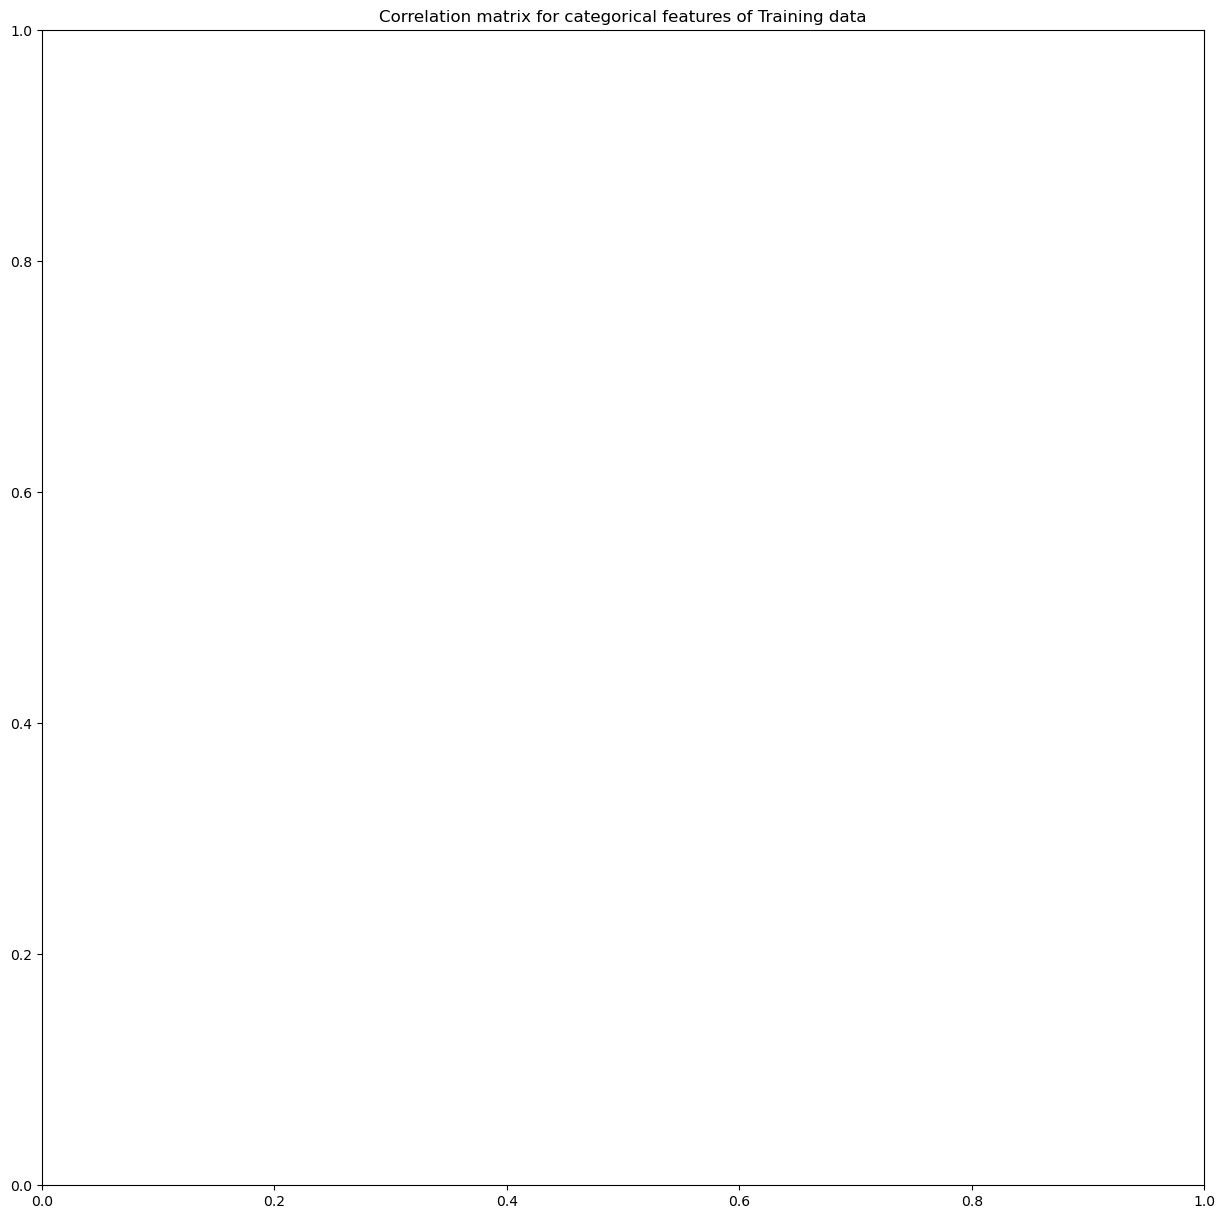

In [114]:
%%time
# Generate correlations in categorical data
corr=train[cat_features].corr()

# create heatmap
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (15, 15))
plt.title('Correlation matrix for categorical features of Training data')
sns.heatmap(corr,cmap='coolwarm', mask = mask,annot=False, linewidths = .5,square=True,cbar_kws={"shrink": .60})
plt.show()

initial correlations calculated
highest correlations calculated


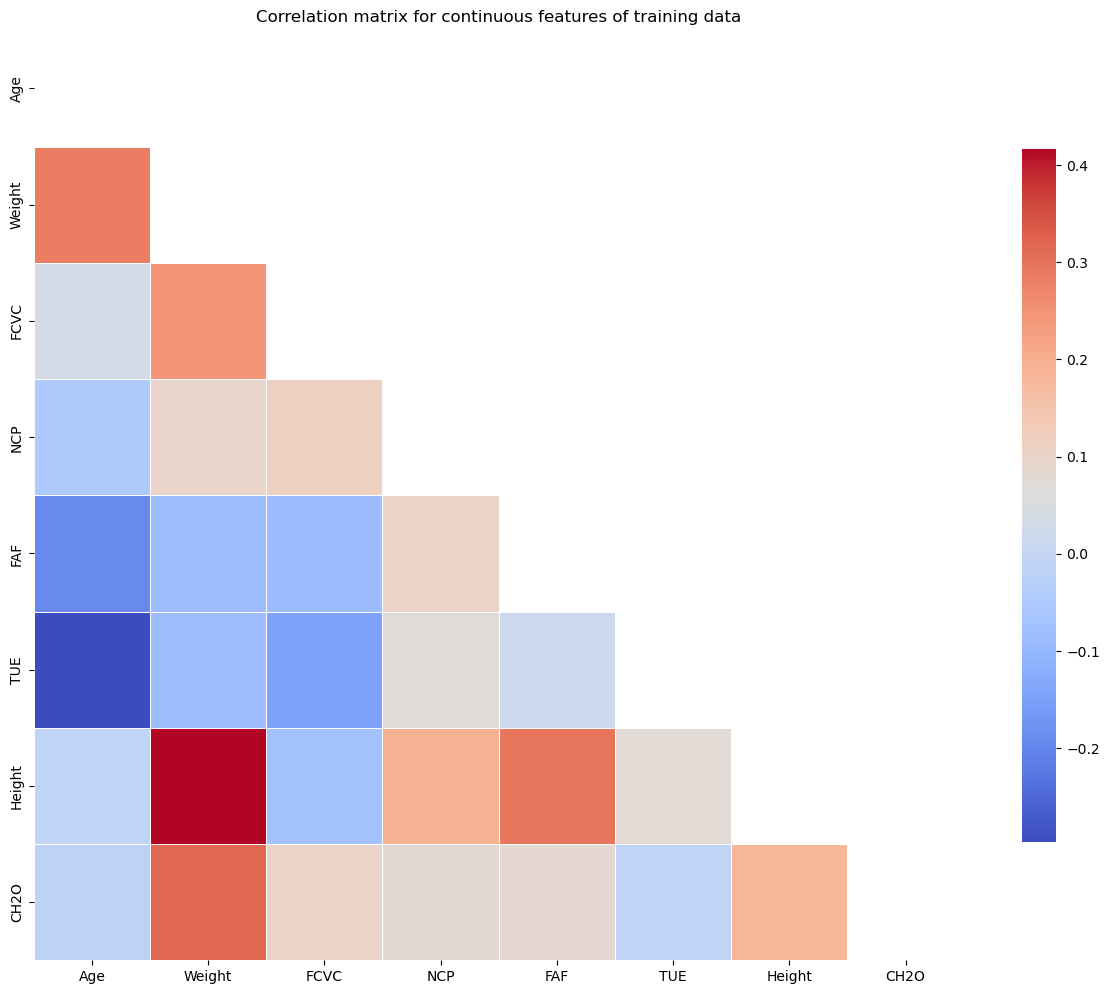

CPU times: total: 422 ms
Wall time: 650 ms


In [115]:
%%time
# get list of columns with high correlations
corr = train[cont_features].corr().abs()
high_corr=np.where(corr>0.02)
high_corr=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr) if x!=y and x<y]
print('initial correlations calculated')
#print("high correlation \n",high_corr)
high_corr_features=[]
for x in high_corr:
    for item in x:
        if item not in high_corr_features:
            high_corr_features.append(item)
corr_matrix = train[high_corr_features].corr()
print('highest correlations calculated')

# create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
plt.figure(figsize = (15, 15))
plt.title('Correlation matrix for continuous features of training data')
sns.heatmap(corr_matrix, cmap='coolwarm',mask = mask,annot=False, linewidths = .5,square=True,cbar_kws={"shrink": .60})
plt.show()

In [116]:
%%time
# correlations to target
# idea/code taken https://www.kaggle.com/rahullalu/tps-oct-2021-eda-and-baseline

corr_cat=pd.DataFrame()
corr_cat['Y'] = train[cat_features].corrwith(train['Y'])
df_cat=corr_cat.sort_values(by='Y', ascending=False)

corr_cont=pd.DataFrame()
corr_cont['Y'] = train[high_corr_features].corrwith(train['Y'])
df_cont=corr_cont.sort_values(by='Y', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Correlation to Target')

heatmap = sns.heatmap(ax=axes[0],data=df_cat,annot=True,cmap='tab20c',linewidth=0.5,xticklabels=df_cat.columns,yticklabels=df_cat.index)
heatmap = sns.heatmap(ax=axes[1],data=df_cont,annot=True,cmap='tab20c',linewidth=0.5,xticklabels=df_cont.columns,yticklabels=df_cont.index)
plt.show()

corr_cont=pd.DataFrame()
corr_cont['Y'] = train[cont_features].corrwith(train['Y'])
df_cont=corr_cont.sort_values(by='Y', ascending=False)

del df_cont, df_cat, corr_cat, corr_cont

KeyError: 'Y'

In [117]:
# Feature importance catboost

import catboost as cat

X=train[cat_features]
y=train['NObeyesdad']
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8,test_size = 0.2,random_state = 0)

# instanciate and fit model
cat_checker = cat.CatBoostClassifier(learning_rate=0.05,
                              n_estimators=1000,
                              reg_lambda = 1, 
                              random_seed=42)

cat_checker.fit(X_train, y_train, cat_features=cat_features)

0:	learn: 1.8668332	total: 365ms	remaining: 6m 4s
1:	learn: 1.8026712	total: 550ms	remaining: 4m 34s
2:	learn: 1.7497252	total: 767ms	remaining: 4m 14s
3:	learn: 1.7043388	total: 908ms	remaining: 3m 46s
4:	learn: 1.6646815	total: 1.06s	remaining: 3m 30s
5:	learn: 1.6300754	total: 1.19s	remaining: 3m 17s
6:	learn: 1.5925242	total: 1.35s	remaining: 3m 12s
7:	learn: 1.5639989	total: 1.63s	remaining: 3m 21s
8:	learn: 1.5347909	total: 1.79s	remaining: 3m 17s
9:	learn: 1.5086993	total: 1.99s	remaining: 3m 16s
10:	learn: 1.4868166	total: 2.18s	remaining: 3m 15s
11:	learn: 1.4637907	total: 2.53s	remaining: 3m 28s
12:	learn: 1.4442463	total: 3.04s	remaining: 3m 50s
13:	learn: 1.4262995	total: 3.19s	remaining: 3m 44s
14:	learn: 1.4088800	total: 3.37s	remaining: 3m 41s
15:	learn: 1.3929480	total: 3.59s	remaining: 3m 40s
16:	learn: 1.3808798	total: 3.75s	remaining: 3m 37s
17:	learn: 1.3681370	total: 3.89s	remaining: 3m 32s
18:	learn: 1.3562212	total: 4.06s	remaining: 3m 29s
19:	learn: 1.3461165	to

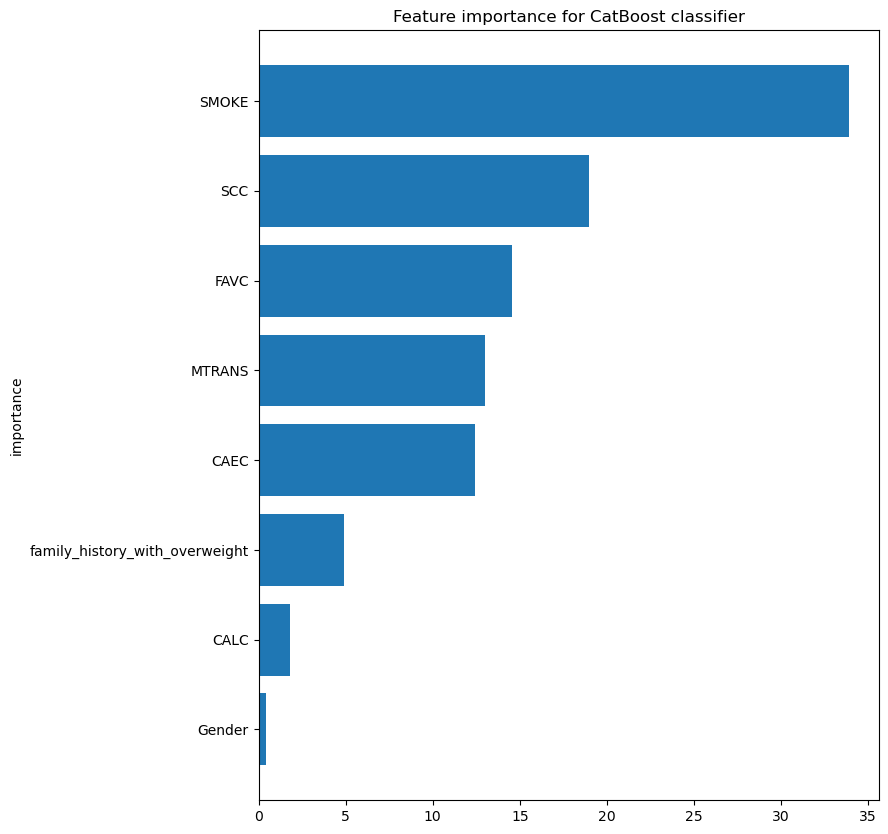

In [118]:
# put feature impoartance into table
importances_df = pd.DataFrame(cat_checker.get_feature_importance(), columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
#print(importances_df)

# plot importance as bar chart
importances=importances_df.index
importances_df = importances_df.sort_values(['Feature_Importance'])
y_pos = np.arange(len(importances_df))
plt.figure(figsize=(8,10))
plt.barh(y_pos,importances_df['Feature_Importance'])
plt.yticks(y_pos, importances,fontsize=10)
plt.ylabel('importance')
plt.title('Feature importance for CatBoost classifier')
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 8
[LightGBM] [Info] Start training from score -2.094366
[LightGBM] [Info] Start training from score -1.912860
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.863915
[LightGBM] [Info] Start training from score -1.634499
[LightGBM] [Info] Start training from score -2.139374
[LightGBM] [Info] Start training from score -2.110635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

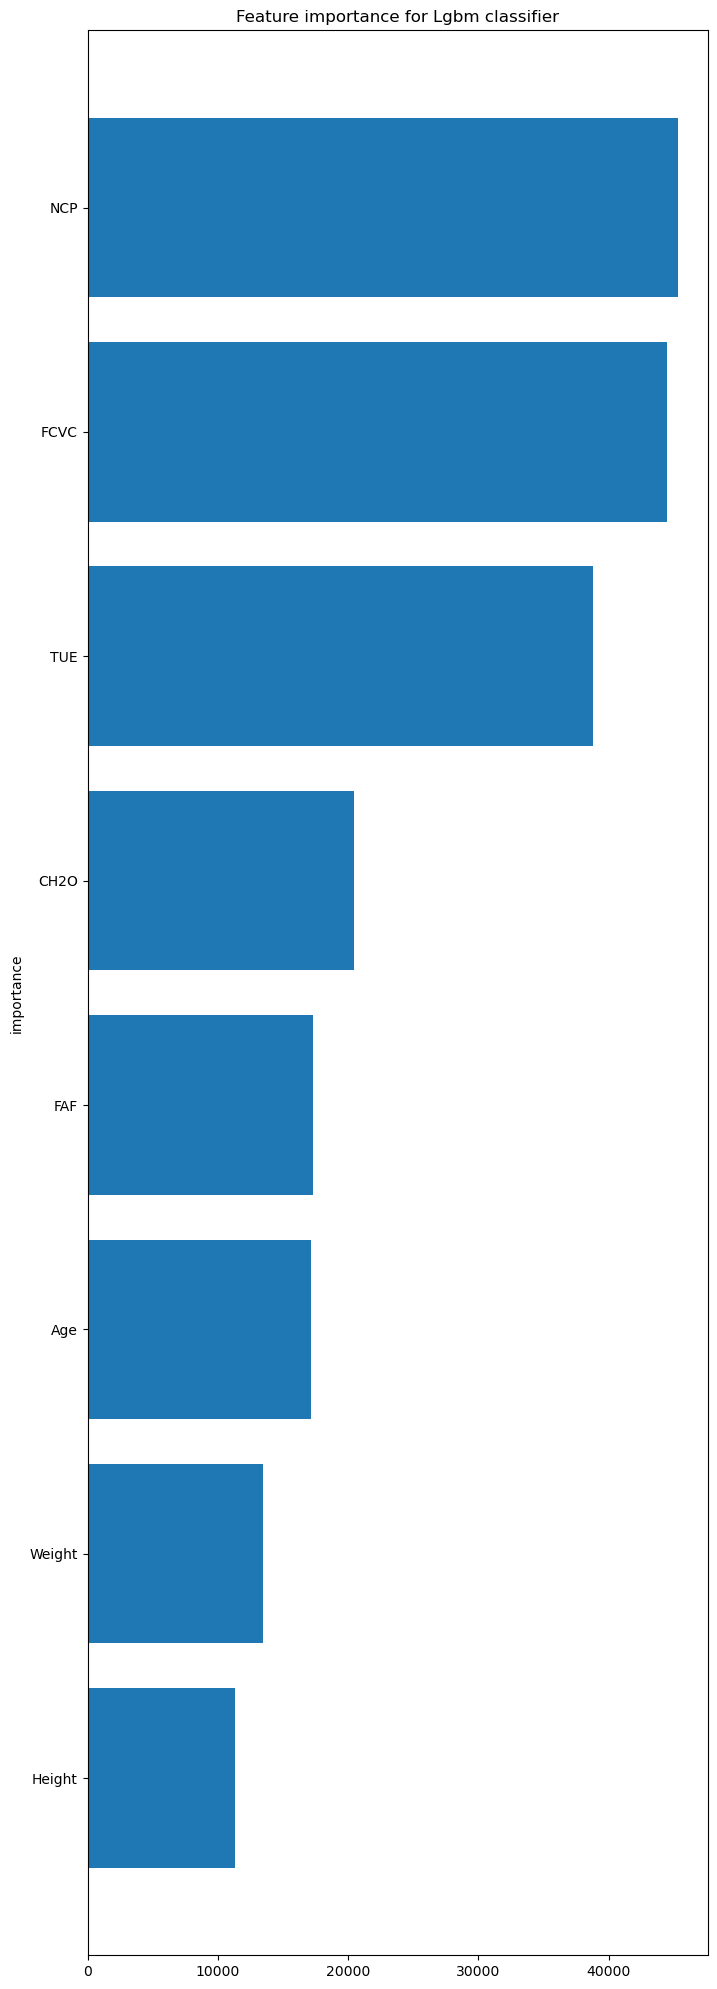

In [119]:
# Feature importance lgbm
X=train[cont_features]
y=train['NObeyesdad']
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,train_size=0.8,test_size = 0.2,random_state = 0)

# instanciate and fit model
lgbm_checker = LGBMClassifier(learning_rate=0.05,
                              n_estimators=1000,
                              reg_lambda = 1)

lgbm_checker.fit(X_train, y_train)

# put feature impoartance into table
importances_df = pd.DataFrame(lgbm_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
#print(importances_df)

# plot importance as bar chart
importances=importances_df.index
importances_df = importances_df.sort_values(['Feature_Importance'])
y_pos = np.arange(len(importances_df))
plt.figure(figsize=(8,25))
plt.barh(y_pos,importances_df['Feature_Importance'])
plt.yticks(y_pos, importances,fontsize=10)
plt.ylabel('importance')
plt.title('Feature importance for Lgbm classifier')
plt.show()

Number of predictors:  17
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\BQTX\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\BQTX\AppData\Local\Temp\tmp8zv8c7yi
  JVM stdout: C:\Users\BQTX\AppData\Local\Temp\tmp8zv8c7yi\h2o_BQTX_started_from_python.out
  JVM stderr: C:\Users\BQTX\AppData\Local\Temp\tmp8zv8c7yi\h2o_BQTX_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_BQTX_5i9beu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


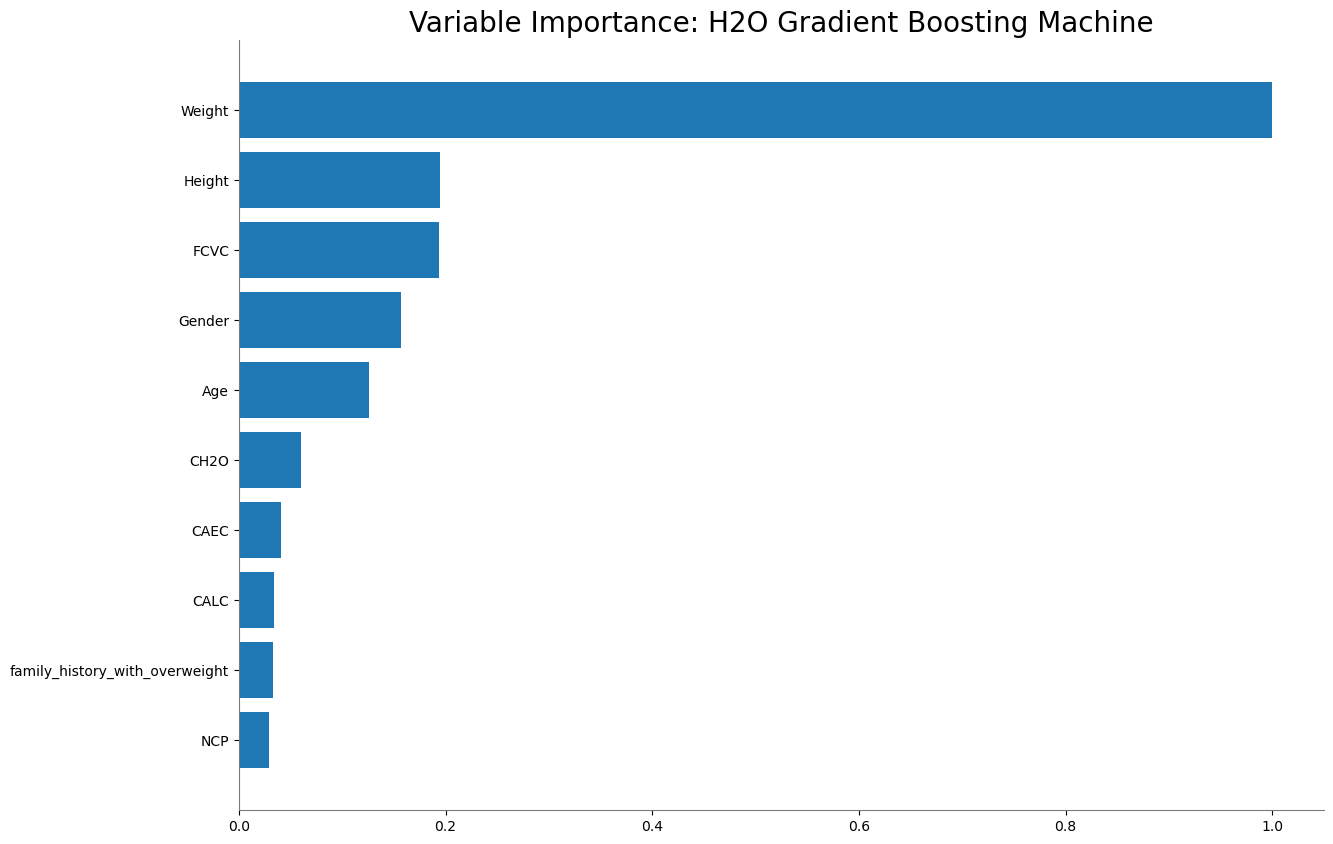

CPU times: total: 562 ms
Wall time: 53.7 s


<Figure size 640x480 with 0 Axes>

In [120]:
%%time
#taken from https://www.kaggle.com/docxian/tabular-playground-10-first-glance-baseline/notebook#Model 

# extract list of features
features = train.columns.tolist()
features.remove('NObeyesdad')

# select predictors
predictors = features
print('Number of predictors: ', len(predictors))

# start H2O
h2o.init(max_mem_size='12G', nthreads=4) # define maximum memory usage and number of cores

# upload data in H2O environment
# let's start with a SUBSET of training data only to reduce RAM use!
n_sub = 2853
train_sub = train.sample(n=n_sub, random_state=42)
train_hex = h2o.H2OFrame(train_sub)

# force categorical target
train_hex['NObeyesdad'] = train_hex['NObeyesdad'].asfactor()

# fit Gradient Boosting model
n_cv = 5 # 5 folds

fit_GBM = H2OGradientBoostingEstimator(ntrees=250,
                                       max_depth=6,
                                       min_rows=10,
                                       learn_rate=0.1, # default: 0.1
                                       sample_rate=1,
                                       col_sample_rate=0.5,
                                       nfolds=n_cv,
                                       score_each_iteration=True,
                                       stopping_metric='auc',
                                       stopping_rounds=5,
                                       stopping_tolerance=0.0001*0.5,
                                       seed=999)
# train model
fit_GBM.train(x=predictors,
              y='NObeyesdad',
              training_frame=train_hex)

# variable importance
fit_GBM.varimp_plot()

# alternative variable importance using SHAP => see direction as well as severity of feature impact
#fit_GBM.shap_summary_plot(train_hex)

Edited

In [121]:
from sklearn import manifold
import matplotlib.pyplot as plt
from matplotlib import ticker


In [122]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())



In [123]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns

In [124]:
n_components=2
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=3000,
    random_state=0,
    verbose=True
)

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features[:-1]),
        ]
    )

X=train.drop(columns='NObeyesdad')
y=train['NObeyesdad']
X_2=ordinalCatRobustCT.fit_transform(X, y)

In [125]:
S_t_sne = t_sne.fit_transform(X_2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20758 samples in 0.068s...
[t-SNE] Computed neighbors for 20758 samples in 5.153s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20758
[t-SNE] Computed conditional probabilities for sample 2000 / 20758
[t-SNE] Computed conditional probabilities for sample 3000 / 20758
[t-SNE] Computed conditional probabilities for sample 4000 / 20758
[t-SNE] Computed conditional probabilities for sample 5000 / 20758
[t-SNE] Computed conditional probabilities for sample 6000 / 20758
[t-SNE] Computed conditional probabilities for sample 7000 / 20758
[t-SNE] Computed conditional probabilities for sample 8000 / 20758
[t-SNE] Computed conditional probabilities for sample 9000 / 20758
[t-SNE] Computed conditional probabilities for sample 10000 / 20758
[t-SNE] Computed conditional probabilities for sample 11000 / 20758
[t-SNE] Computed conditional probabilities for sample 12000 / 20758
[t-SNE] Computed conditional probabilities for sam

In [126]:
df = pd.DataFrame()

tsne_2d_one = S_t_sne[:,0]
tsne_2d_two = S_t_sne[:,1]

df['tsne_2d_one'] = tsne_2d_one
df['tsne_2d_two'] = tsne_2d_two
df['y'] = y
df = df.sort_values(by=['y'])

<Axes: xlabel='tsne_2d_one', ylabel='tsne_2d_two'>

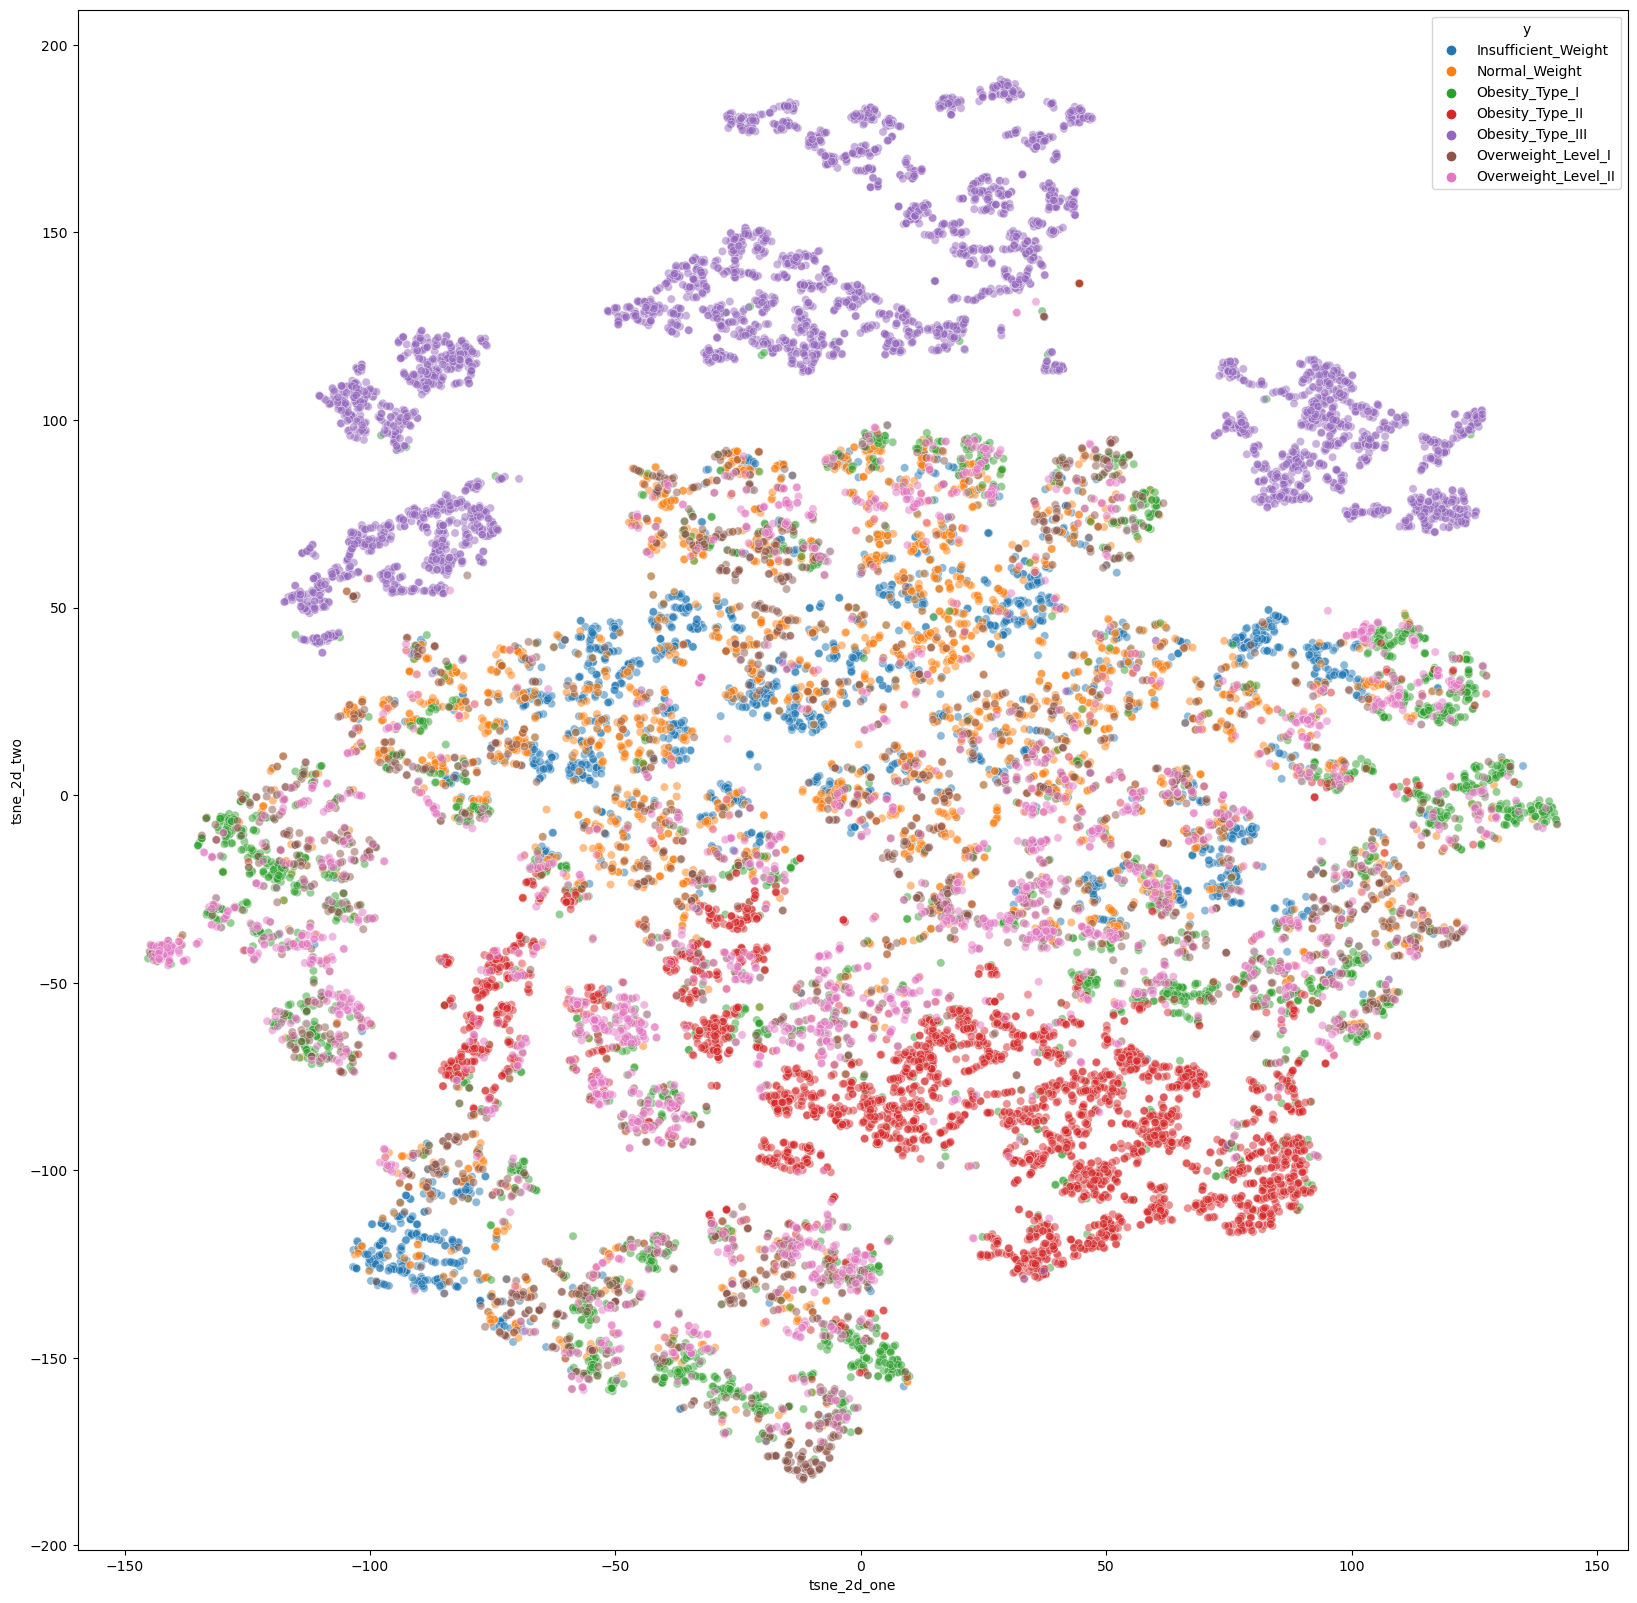

In [127]:
fig, ax = plt.subplots(figsize=[20,20])
sns.scatterplot(
    ax=ax,
    x="tsne_2d_one", y="tsne_2d_two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=df,
    legend="full",
    alpha=0.5
)

In [128]:
n_components=3
t_sne2 = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=3000,
    random_state=42,
    verbose=True
)

In [129]:
S_t_sne2 = t_sne2.fit_transform(X_2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20758 samples in 0.070s...
[t-SNE] Computed neighbors for 20758 samples in 5.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20758
[t-SNE] Computed conditional probabilities for sample 2000 / 20758
[t-SNE] Computed conditional probabilities for sample 3000 / 20758
[t-SNE] Computed conditional probabilities for sample 4000 / 20758
[t-SNE] Computed conditional probabilities for sample 5000 / 20758
[t-SNE] Computed conditional probabilities for sample 6000 / 20758
[t-SNE] Computed conditional probabilities for sample 7000 / 20758
[t-SNE] Computed conditional probabilities for sample 8000 / 20758
[t-SNE] Computed conditional probabilities for sample 9000 / 20758
[t-SNE] Computed conditional probabilities for sample 10000 / 20758
[t-SNE] Computed conditional probabilities for sample 11000 / 20758
[t-SNE] Computed conditional probabilities for sample 12000 / 20758
[t-SNE] Computed conditional probabilities for sam

In [130]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

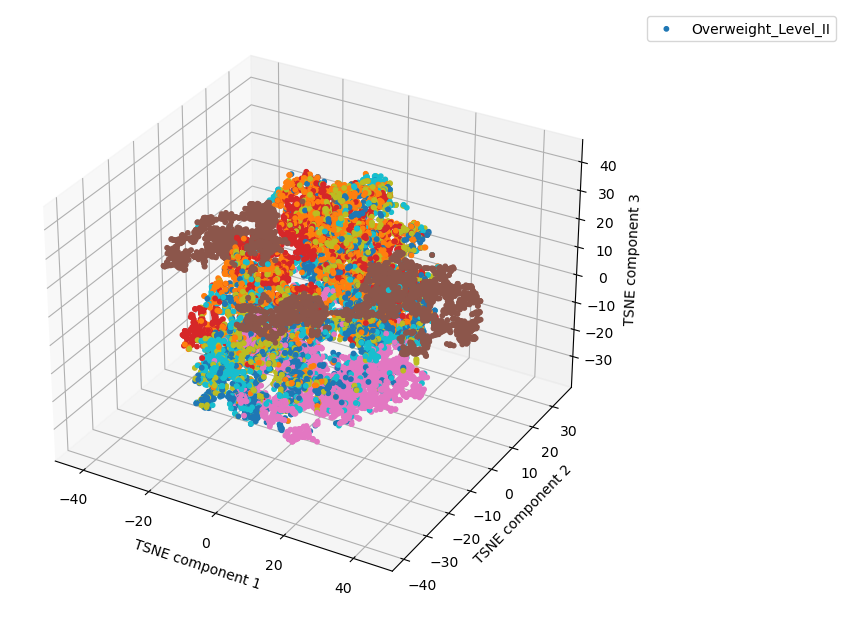

In [131]:
# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

x2 = S_t_sne2[:,0]
y2 = S_t_sne2[:,1]
z2 = S_t_sne2[:,2]

templist = []
count = []

for val in y.values:
    if val not in templist:
        templist.append(val)
    count.append(templist.index(val))

# plot
sc = ax.scatter(x2, y2, z2, s=10, c=count, marker='o', cmap = 'tab10',alpha=1)
ax.set_xlabel('TSNE component 1')
ax.set_ylabel('TSNE component 2')
ax.set_zlabel('TSNE component 3')

# legend
plt.legend(templist, bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')